Experimental Trials

In [ ]:
import os
import json
import logging
import requests
import re
import time
from sqlalchemy import create_engine, inspect, text
import pandas as pd
from dotenv import load_dotenv
from tqdm.notebook import tqdm
from typing import List, Optional, Dict, Tuple
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import tiktoken
from concurrent.futures import ThreadPoolExecutor, as_completed
import networkx as nx
from sentence_transformers import SentenceTransformer
from joblib import Parallel, delayed
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Load environment variables
load_dotenv()

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)

# Configuration class
class Config:
    # Database configuration
    DATABASE = {
        'database': os.getenv('DB_NAME', 'maude'),
        'user': os.getenv('DB_USER', 'postgres'),
        'password': os.getenv('DB_PASSWORD', '12345687'),
        'host': os.getenv('DB_HOST', '192.168.8.167'),
        'port': os.getenv('DB_PORT', '5432')
    }
    SCHEMA = 'maude'
    SAMPLE_SIZE = 3  # Number of sample data per table
    OUTPUT_DIR = os.getenv('OUTPUT_DIR', 'maude_schema_analysis')
    COMBINED_OUTPUT_FILE = os.getenv('COMBINED_OUTPUT_FILE', 'maude_schema_combined.txt')
    DEEPSEEK_API_KEY = os.getenv('DEEPSEEK_API_KEY')
    DEEPSEEK_BASE_URL = os.getenv('DEEPSEEK_BASE_URL', 'https://api.deepseek.com/v1')
    OUTPUT_ANALYSIS_FILE = os.getenv('OUTPUT_ANALYSIS_FILE', 'maude_schema_analysis.json')
    RETRY_LIMIT = int(os.getenv('RETRY_LIMIT', 2))  # Number of retries for failed API calls
    OVERWRITE_EXISTING = os.getenv('OVERWRITE_EXISTING', 'True').lower() in ['true', '1', 't']  # Whether to overwrite existing fields
    MAX_TOKENS = int(os.getenv('MAX_TOKENS', 100000))  # Maximum token limit, adjust based on actual API
    # Similarity thresholds list
    SIMILARITY_THRESHOLDS = [0.7, 0.8, 0.9]  # Similarity thresholds for merging
    PREFILTER_JACCARD_THRESHOLD = 0.1  # Pre-filtering Jaccard similarity threshold
    DISTANCE_THRESHOLDS = [1.0]  # Distance thresholds for hierarchical clustering (simplified to a single value)
    GLOBAL_CONTEXT_FILE = os.getenv('GLOBAL_CONTEXT_FILE', 'context.txt')  # Path to global context file
    USE_HIERARCHICAL_CLUSTERING = os.getenv('USE_HIERARCHICAL_CLUSTERING', 'True').lower() in ['true', '1', 't']
    ENABLE_SIMILARITY_CALCULATION = os.getenv('ENABLE_SIMILARITY_CALCULATION', 'True').lower() in ['true', '1', 't']  # Whether to enable similarity calculation and merging
    # Path to manual grouping standard result file (expert-based)
    MANUAL_GROUPING_FILE = os.getenv('MANUAL_GROUPING_FILE', 'manual_grouping.json')
    # Path to save evaluation results
    EVALUATION_RESULTS_FILE = os.getenv('EVALUATION_RESULTS_FILE', 'evaluation_results.csv')
    # Clustering methods and parameters (simplified to K-Means, Hierarchical, DBSCAN)
    CLUSTERING_METHODS = {
        'kmeans_manual': {
            'params': [3, 4, 5, 6, 7],
            'description': 'K-Means clustering with manually specified cluster counts'
        },
        'kmeans_auto': {
            'params': [None],  # None indicates automatic detection
            'description': 'K-Means clustering with automatic detection of optimal cluster count'
        },
        'hierarchical': {
            'params': [0.8, 1.0, 1.2],
            'description': 'Hierarchical clustering with varying distance thresholds'
        },
        'dbscan_manual': {
            'params': [(0.5, 5), (0.6, 5), (0.7, 5)],
            'description': 'DBSCAN clustering with varying ε values and min_samples=5'
        },
        'dbscan_auto': {
            'params': [None],  # None indicates automatic parameter selection
            'description': 'DBSCAN clustering with automatic selection of ε'
        }
    }

    # Cache file path
    CACHE_FILE = os.getenv('CACHE_FILE', 'similarity_cache.json')
    # Whether to enable PCA dimensionality reduction
    ENABLE_PCA = os.getenv('ENABLE_PCA', 'True').lower() in ['true', '1', 't']
    # Feature extraction methods
    FEATURE_EXTRACTION_METHODS = ['tfidf', 'sentence_transformer']  # 'tfidf' or 'sentence_transformer'

# Create output directory
def create_output_directory(output_dir: str):
    """Create the output directory if it does not exist."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        logging.info(f"Created output directory: {output_dir}")
    else:
        logging.info(f"Output directory already exists: {output_dir}")

# Create and return a SQLAlchemy engine
def get_database_engine(db_config: dict):
    """Create and return a SQLAlchemy engine."""
    db_uri = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
    try:
        engine = create_engine(db_uri)
        # Test connection
        with engine.connect() as connection:
            connection.execute(text("SELECT 1"))
        logging.info("Successfully connected to the database.")
        return engine
    except Exception as e:
        logging.error(f"Failed to connect to the database: {e}")
        raise

# Get all table names in the specified schema
def get_all_tables(engine, schema: str) -> list:
    """Retrieve all table names in the specified schema."""
    inspector = inspect(engine)
    tables = inspector.get_table_names(schema=schema)
    logging.info(f"Found {len(tables)} tables in schema '{schema}'.")
    return tables

# Get the structure information of a specified table
def get_table_structure(inspector, table_name: str, schema: str) -> list:
    """Retrieve the structure information of a specified table."""
    try:
        columns = inspector.get_columns(table_name, schema=schema)
        column_info = [{
            'name': column['name'],
            'type': str(column['type']),
            'nullable': column['nullable'],
            'default': str(column['default']) if column['default'] else None
        } for column in columns]
        return column_info
    except Exception as e:
        logging.error(f"Error retrieving table structure ({table_name}): {e}")
        return []

# Get sample data from a specified table
def get_sample_data(engine, table_name: str, schema: str, sample_size: int) -> list:
    """Retrieve sample data from a specified table."""
    try:
        query = f'SELECT * FROM "{schema}"."{table_name}" LIMIT {sample_size};'
        df = pd.read_sql(query, engine)
        sample_data = df.to_dict(orient='records')
        return sample_data
    except Exception as e:
        logging.error(f"Error retrieving sample data ({table_name}): {e}")
        return []

# Anonymize sample data by redacting sensitive fields
def anonymize_sample_data(sample_data: List[Dict[str, any]]) -> List[Dict[str, any]]:
    """
    Anonymize sample data by redacting or obfuscating sensitive fields.
    Customize as needed.
    """
    sensitive_fields = ['patient_id', 'first_name', 'last_name', 'date_of_birth', 'name', 'address']
    anonymized_data = []
    for record in sample_data:
        anonymized_record = {}
        for key, value in record.items():
            if key in sensitive_fields:
                anonymized_record[key] = "REDACTED"
            else:
                anonymized_record[key] = value
        anonymized_data.append(anonymized_record)
    return anonymized_data

# Save table structure and sample data to a JSON file and validate JSON format
def save_table_info(output_dir: str, table_name: str, structure: list, samples: list):
    """Save table structure and sample data to a JSON file and validate JSON format."""
    # Anonymize sample data
    anonymized_samples = anonymize_sample_data(samples)
    
    data = {
        'table_name': table_name,
        'structure': structure,
        'sample_data': anonymized_samples
    }
    file_path = os.path.join(output_dir, f"{table_name}.json")
    try:
        with open(file_path, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=4, ensure_ascii=False)
        
        # Validate JSON file
        with open(file_path, 'r', encoding='utf-8') as f:
            json.load(f)  # Attempt to reload to ensure JSON is valid
        
        logging.info(f"Saved and validated data for table '{table_name}' to '{file_path}'.")
    except json.JSONDecodeError as e:
        logging.error(f"Invalid JSON generated when saving table '{table_name}': {e}")
    except Exception as e:
        logging.error(f"Error saving table data ({table_name}): {e}")

# Generate table description including fields and sample data summary for similarity analysis
def generate_table_description(table_name: str, structure: list, samples: list) -> str:
    """
    Generate a description of the table, including fields and a summary of sample data, for similarity analysis.
    """
    description = f"Table '{table_name}' has the following fields: "
    fields = [f"{column['name']} ({column['type']})" for column in structure]
    description += ", ".join(fields) + ". "
    
    if samples:
        description += "Sample data includes: "
        sample_summaries = []
        for column in structure:
            col_name = column['name']
            # Extract the first 3 sample values for each column
            sample_values = [str(record[col_name]) for record in samples[:3] if col_name in record]
            if sample_values:
                sample_summaries.append(f"{col_name} values like {', '.join(sample_values)}")
        description += "; ".join(sample_summaries) + "."
    
    return description

# Retrieve descriptions for all tables
def get_all_table_descriptions(config: Config) -> Dict[str, str]:
    """
    Retrieve descriptions for all tables, including sample data summaries.
    Returns a dictionary with table names as keys and descriptions as values.
    """
    descriptions = {}
    json_files = [f for f in os.listdir(config.OUTPUT_DIR) if f.endswith('.json')]
    for json_file in json_files:
        file_path = os.path.join(config.OUTPUT_DIR, json_file)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            table_name = data.get('table_name', 'Unknown Table')
            structure = data.get('structure', [])
            samples = data.get('sample_data', [])
            description = generate_table_description(table_name, structure, samples)
            descriptions[table_name] = description
        except json.JSONDecodeError as e:
            logging.error(f"JSON parsing error in file '{json_file}': {e}")
            # Optionally, delete the problematic file
            try:
                os.remove(file_path)
                logging.info(f"Deleted problematic file '{json_file}'.")
            except Exception as remove_error:
                logging.error(f"Error deleting file '{json_file}': {remove_error}")
            continue  # Skip the problematic file
        except Exception as e:
            logging.error(f"Error processing file '{json_file}': {e}")
            continue
    return descriptions

# Call the DeepSeek API
def call_deepseek_api(prompt: str, config: Config) -> str:
    """
    Call the DeepSeek API and return the response content.
    """
    headers = {
        "Authorization": f"Bearer {config.DEEPSEEK_API_KEY}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": "deepseek-chat",
        "messages": [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        "stream": False
    }

    for attempt in range(1, config.RETRY_LIMIT + 1):
        try:
            start_time = time.time()
            response = requests.post(
                f"{config.DEEPSEEK_BASE_URL}/chat/completions",
                headers=headers,
                data=json.dumps(payload),
                timeout=300  # Increase timeout to handle long texts
            )
            elapsed_time = time.time() - start_time
            logging.info(f"API call attempt {attempt}, took {elapsed_time:.2f} seconds.")

            if response.status_code == 200:
                result = response.json()
                content = result.get('choices', [{}])[0].get('message', {}).get('content', '').strip()
                
                # Check JSON integrity
                if content.count('{') == content.count('}'):
                    return content
                else:
                    logging.error(f"Incomplete JSON returned, retrying API call. Attempt {attempt}.")
            else:
                logging.error(f"DeepSeek API error {response.status_code}: {response.text}")
        except requests.exceptions.RequestException as e:
            logging.error(f"API call exception on attempt {attempt}: {e}")

        if attempt < config.RETRY_LIMIT:
            logging.info(f"Waiting before retrying... (Attempt {attempt})")

    logging.error("All API call attempts failed.")
    return ""

# Extract JSON object from text
def extract_json_response(text: str) -> Optional[Dict]:
    """
    Extract a JSON object from the given text.
    """
    try:
        # Remove code block markers
        text = re.sub(r'```json', '', text)
        text = re.sub(r'```', '', text)
        
        # Find the complete JSON object
        json_match = re.search(r'\{.*\}', text, re.DOTALL)
        if not json_match:
            logging.error("No JSON object found in the response.")
            return None
        json_str = json_match.group()
        json_obj = json.loads(json_str)
        
        return json_obj
    except json.JSONDecodeError as e:
        logging.error(f"JSON decoding error: {e}")
        return None
    except Exception as e:
        logging.error(f"Error extracting JSON: {e}")
        return None

# Generate TF-IDF feature vectors
def generate_tfidf_features(descriptions: Dict[str, str]) -> Tuple[np.ndarray, List[str]]:
    """
    Generate TF-IDF feature vectors for table descriptions.
    """
    vectorizer = TfidfVectorizer()
    table_names = list(descriptions.keys())
    corpus = [descriptions[table] for table in table_names]
    tfidf_matrix = vectorizer.fit_transform(corpus)
    return tfidf_matrix.toarray(), table_names

# Generate SentenceTransformer embeddings
def generate_sentence_embeddings(descriptions: Dict[str, str], model_name: str = 'all-MiniLM-L6-v2') -> Tuple[np.ndarray, List[str]]:
    """
    Generate SentenceTransformer embeddings for table descriptions.
    """
    model = SentenceTransformer(model_name)
    table_names = list(descriptions.keys())
    corpus = [descriptions[table] for table in table_names]
    embeddings = model.encode(corpus, show_progress_bar=True)
    return embeddings, table_names

# Perform PCA dimensionality reduction
def reduce_dimensionality(feature_matrix: np.ndarray, n_components: int = 100) -> np.ndarray:
    """
    Perform PCA dimensionality reduction on the feature matrix.
    """
    pca = PCA(n_components=n_components, random_state=42)
    reduced_matrix = pca.fit_transform(feature_matrix)
    logging.info(f"Dimensionality reduced to: {reduced_matrix.shape}")
    return reduced_matrix

# Hierarchical Clustering
def cluster_tables_hierarchical(tfidf_matrix: np.ndarray, distance_threshold: float, table_names: List[str]) -> List[List[str]]:
    """
    Perform hierarchical clustering on tables.
    """
    # Compute distance matrix
    distance_matrix = cosine_distances(tfidf_matrix)
    
    clustering = AgglomerativeClustering(
        n_clusters=None,
        metric='precomputed',
        linkage='average',
        distance_threshold=distance_threshold
    )
    clustering.fit(distance_matrix)
    
    labels = clustering.labels_
    clusters = {}
    for table, label in zip(table_names, labels):
        clusters.setdefault(label, []).append(table)
    return list(clusters.values())

# K-Means Clustering
def cluster_tables_kmeans(tfidf_matrix: np.ndarray, n_clusters: Optional[int], table_names: List[str]) -> List[List[str]]:
    """
    Perform K-Means clustering on tables.
    If n_clusters is None, automatically detect the optimal number of clusters.
    """
    if n_clusters is None:
        logging.info("Automatically detecting the number of K-Means clusters.")
        optimal_k = find_optimal_kmeans_clusters(tfidf_matrix, 2, 20)
        if optimal_k is None:
            logging.error("Unable to determine the optimal number of K-Means clusters, using default K=5.")
            n_clusters = 5
        else:
            n_clusters = optimal_k
            logging.info(f"Optimal number of K-Means clusters detected: {n_clusters}.")
    clustering = KMeans(n_clusters=n_clusters, random_state=42)
    clustering.fit(tfidf_matrix)
    labels = clustering.labels_
    clusters = {}
    for table, label in zip(table_names, labels):
        clusters.setdefault(label, []).append(table)
    return list(clusters.values())

# DBSCAN Clustering
def cluster_tables_dbscan(feature_matrix: np.ndarray, eps: Optional[float], min_samples: int, table_names: List[str], config: Config) -> List[List[str]]:
    """
    Perform DBSCAN clustering on tables.
    If eps is None, automatically select parameters.
    """
    if eps is None:
        logging.info("Automatically selecting DBSCAN parameters.")
        eps = find_dbscan_eps(feature_matrix)
        if eps is None:
            logging.error("Unable to determine DBSCAN's eps value automatically, using default eps=0.5.")
            eps = 0.5
        logging.info(f"Automatically selected DBSCAN eps value: {eps}.")
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    labels = clustering.fit_predict(feature_matrix)
    clusters = {}
    for table, label in zip(table_names, labels):
        if label == -1:
            continue  # Ignore noise points
        clusters.setdefault(label, []).append(table)
    return list(clusters.values())

# Automatically select DBSCAN's eps value using k-distance graph
def find_dbscan_eps(feature_matrix: np.ndarray, k: int = 4) -> Optional[float]:
    """
    Automatically select DBSCAN's eps value using the k-distance graph.
    
    Parameters:
    - feature_matrix: Feature matrix of tables
    - k: The k-th nearest neighbor
    
    Returns:
    - Selected eps value, or None if unable to determine
    """
    from sklearn.neighbors import NearestNeighbors

    try:
        neighbors = NearestNeighbors(n_neighbors=k)
        neighbors_fit = neighbors.fit(feature_matrix)
        distances, indices = neighbors_fit.kneighbors(feature_matrix)
        distances = np.sort(distances[:, k-1], axis=0)
        # Plot the k-distance graph
        plt.figure(figsize=(10, 6))
        plt.plot(distances)
        plt.ylabel(f"{k}-Distance")
        plt.xlabel("Sample Index")
        plt.title(f"{k}-Distance Graph for Selecting DBSCAN eps")
        plt.grid(True)
        plt.show()
        
        # Find the elbow point (knee)
        # Use the difference method to find the largest second derivative
        diff = np.diff(distances)
        diff2 = np.diff(diff)
        elbow_index = np.argmax(diff2) + 2  # +2 because diff2 is offset by two elements
        eps = distances[elbow_index]
        logging.info(f"Selected DBSCAN eps value based on k-distance graph: {eps}.")
        return eps
    except Exception as e:
        logging.error(f"Error automatically selecting DBSCAN eps value: {e}")
        return None

# Automatically detect the optimal number of K-Means clusters using Silhouette Score
def find_optimal_kmeans_clusters(tfidf_matrix: np.ndarray, min_k: int = 2, max_k: int = 20) -> Optional[int]:
    """
    Automatically determine the optimal number of K-Means clusters using the Silhouette Score.
    
    Parameters:
    - tfidf_matrix: TF-IDF feature matrix of table descriptions
    - min_k: Minimum number of clusters
    - max_k: Maximum number of clusters
    
    Returns:
    - Optimal number of clusters, or None if unable to determine
    """
    best_k = None
    best_score = -1
    for k in range(min_k, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(tfidf_matrix)
        if len(set(labels)) == 1:
            # Silhouette Score cannot be calculated
            continue
        score = silhouette_score(tfidf_matrix, labels)
        logging.info(f"K-Means Clusters: {k}, Silhouette Score: {score:.4f}")
        if score > best_score:
            best_score = score
            best_k = k
    if best_k is not None:
        logging.info(f"Optimal number of K-Means clusters: {best_k}, Silhouette Score: {best_score:.4f}")
    else:
        logging.warning("Unable to determine the optimal number of K-Means clusters.")
    return best_k

# Load similarity cache
def load_cache(cache_file: str) -> Dict[str, float]:
    """
    Load the similarity cache.
    """
    if os.path.exists(cache_file):
        try:
            with open(cache_file, 'r', encoding='utf-8') as f:
                cache = json.load(f)
            logging.info(f"Successfully loaded cache file '{cache_file}'.")
            return cache
        except Exception as e:
            logging.error(f"Error loading cache file '{cache_file}': {e}")
            return {}
    else:
        logging.info(f"Cache file '{cache_file}' does not exist, creating a new cache.")
        return {}

# Save similarity cache
def save_cache(cache_file: str, cache: Dict[str, float]):
    """
    Save the similarity cache.
    """
    try:
        with open(cache_file, 'w', encoding='utf-8') as f:
            json.dump(cache, f, ensure_ascii=False, indent=4)
        logging.info(f"Cache saved to '{cache_file}'.")
    except Exception as e:
        logging.error(f"Error saving cache to '{cache_file}': {e}")

# Compute similarity scores within clusters
def compute_similarity_within_clusters(descriptions: Dict[str, str], config: Config, clusters: List[List[str]], max_workers: int = 3) -> Tuple[Dict[Tuple[str, str], float], int]:
    """
    Compute similarity scores for table pairs within each cluster.
    Returns a dictionary of similarity scores and the number of pairs that require similarity computation.
    """
    similarity_scores = {}
    total_pairs = 0
    pairs_to_process = []
    prefilter_threshold = config.PREFILTER_JACCARD_THRESHOLD  # Fixed threshold of 0.1

    # Load cache
    cache = load_cache(config.CACHE_FILE)

    # Generate all necessary table pairs and apply pre-filtering
    for cluster in clusters:
        if len(cluster) < 2:
            continue  # No need to compute similarity for single tables
        n = len(cluster)
        for i in range(n):
            for j in range(i + 1, n):
                pair = tuple(sorted((cluster[i], cluster[j])))
                # Pre-filtering: Jaccard similarity >= prefilter_threshold
                fields1 = set([col.split('(')[0].strip() for col in descriptions[pair[0]].split(': ')[1].split(', ')])
                fields2 = set([col.split('(')[0].strip() for col in descriptions[pair[1]].split(': ')[1].split(', ')])
                intersection = fields1.intersection(fields2)
                union = fields1.union(fields2)
                jaccard = len(intersection) / len(union) if union else 0.0
                total_pairs += 1  # Count total number of table pairs
                if jaccard >= prefilter_threshold:
                    pairs_to_process.append(pair)

    logging.info(f"Total table pairs: {total_pairs}, Pairs passing pre-filtering: {len(pairs_to_process)} (require similarity computation).")

    def compute_pair_similarity(pair: Tuple[str, str]) -> Tuple[Tuple[str, str], float]:
        table1, table2 = pair
        cache_key = f"{table1}|{table2}"
        if cache_key in cache:
            score = cache[cache_key]
            logging.info(f"Retrieved similarity score for tables '{table1}' and '{table2}' from cache: {score}")
            return pair, score

        prompt = f"""
Please evaluate the similarity between the following two database tables. Return a similarity score between 0 and 1, where 0 indicates completely dissimilar and 1 indicates identical similarity.

Table 1 Description: {descriptions[table1]}
Table 2 Description: {descriptions[table2]}

Please return only a JSON object in the format similar to {{"similarity_score": 0.85}} without any additional content.
"""
        start_time = time.time()
        response = call_deepseek_api(prompt, config)
        elapsed_time = time.time() - start_time
        logging.info(f"API call for tables '{table1}' and '{table2}' took {elapsed_time:.2f} seconds.")

        if response:
            json_obj = extract_json_response(response)
            if json_obj and "similarity_score" in json_obj:
                score = float(json_obj["similarity_score"])
                logging.info(f"Similarity score for tables '{table1}' and '{table2}': {score}")
                cache[cache_key] = score  # Update cache
                return pair, score
            else:
                logging.warning(f"Similarity score not found in response for tables '{table1}' and '{table2}'.")
                return pair, 0.0
        else:
            logging.warning(f"No valid similarity score received for tables '{table1}' and '{table2}'.")
            return pair, 0.0

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_pair = {executor.submit(compute_pair_similarity, pair): pair for pair in pairs_to_process}
        for future in as_completed(future_to_pair):
            pair, score = future.result()
            similarity_scores[pair] = score

    # Save updated cache
    save_cache(config.CACHE_FILE, cache)

    return similarity_scores, len(pairs_to_process)  # Return similarity scores and number of pairs processed

# Merge tables based on similarity threshold
def merge_tables_by_similarity(similarity_scores: Dict[Tuple[str, str], float], threshold: float, all_tables: List[str]) -> List[List[str]]:
    """
    Merge tables based on the similarity threshold, ensuring all tables are included in the final clusters.
    
    Parameters:
    - similarity_scores: Dictionary of table pairs and their similarity scores
    - threshold: Similarity threshold for merging
    - all_tables: List of all table names
    
    Returns:
    - List of clusters, each cluster is a list of table names
    """
    G = nx.Graph()
    
    # Add all tables as nodes
    G.add_nodes_from(all_tables)
    
    # Add edges for table pairs that meet the similarity threshold
    for (table1, table2), score in similarity_scores.items():
        if score >= threshold:
            G.add_edge(table1, table2)
    
    # Get all connected components as clusters
    clusters = list(nx.connected_components(G))
    return [list(cluster) for cluster in clusters]

# Load manual grouping results
def load_manual_grouping(file_path: str, ai_grouping: Dict[str, int]) -> Dict[str, int]:
    """
    Load manual grouping results. If the file does not exist, generate an initial file using AI grouping results.
    """
    if os.path.exists(file_path):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                manual_grouping = json.load(f)
            logging.info(f"Successfully loaded manual grouping file '{file_path}'.")
            return manual_grouping
        except Exception as e:
            logging.error(f"Error loading manual grouping file '{file_path}': {e}")
            return {}
    else:
        # If the file does not exist, generate an initial manual grouping file using AI results
        try:
            with open(file_path, 'w', encoding='utf-8') as f:
                json.dump(ai_grouping, f, indent=4, ensure_ascii=False)
            logging.info(f"Manual grouping file '{file_path}' did not exist and has been generated with AI grouping results. Please perform manual adjustments.")
            return ai_grouping
        except Exception as e:
            logging.error(f"Error generating initial manual grouping file '{file_path}': {e}")
            return {}

# Evaluate clustering results by comparing manual and AI groupings
def evaluate_groupings(manual_grouping: Dict[str, int], ai_grouping: Dict[str, int]) -> Dict[str, float]:
    """
    Compare manual grouping results with AI grouping results and calculate evaluation metrics.
    """
    # Convert groupings to lists
    tables = list(manual_grouping.keys())
    manual_labels = [manual_grouping[table] for table in tables]
    ai_labels = [ai_grouping.get(table, -1) for table in tables]  # If AI did not group, mark as -1

    # Calculate evaluation metrics
    ari = adjusted_rand_score(manual_labels, ai_labels)
    nmi = normalized_mutual_info_score(manual_labels, ai_labels)

    # Due to the nature of clustering labels, precision, recall, and f1 require special handling
    from itertools import combinations
    manual_pairs = set()
    ai_pairs = set()
    for (i, j) in combinations(range(len(tables)), 2):
        if manual_labels[i] == manual_labels[j]:
            manual_pairs.add((i, j))
        if ai_labels[i] == ai_labels[j]:
            ai_pairs.add((i, j))

    tp = len(manual_pairs & ai_pairs)
    fp = len(ai_pairs - manual_pairs)
    fn = len(manual_pairs - ai_pairs)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    metrics = {
        'adjusted_rand_index': ari,
        'normalized_mutual_info': nmi,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    return metrics

# Save AI grouping results to a CSV file
def save_groupings_to_csv(ai_grouping: Dict[str, int], config: Config, similarity_threshold: Optional[float], clustering_method: str, clustering_param: float):
    """
    Save AI grouping results to a CSV file, recording each group and the tables it contains.
    """
    # Reverse the grouping mapping: group ID -> [table names]
    group_to_tables = {}
    for table, group_id in ai_grouping.items():
        group_to_tables.setdefault(group_id, []).append(table)
    
    # Create DataFrame
    df = pd.DataFrame({
        'Group ID': list(group_to_tables.keys()),
        'Tables': [', '.join(tables) for tables in group_to_tables.values()]
    })
    
    # Define CSV filename including parameter information
    if similarity_threshold is not None:
        csv_filename = f"groupings_{clustering_method}_sim_{similarity_threshold}_param_{clustering_param}.csv"
    else:
        csv_filename = f"groupings_{clustering_method}_param_{clustering_param}.csv"
    csv_path = os.path.join(config.OUTPUT_DIR, csv_filename)
    
    try:
        df.to_csv(csv_path, index=False, encoding='utf-8-sig')
        logging.info(f"AI grouping results saved to '{csv_path}'.")
    except Exception as e:
        logging.error(f"Error saving AI grouping results to CSV: {e}")

# Count the number of tokens in text using tiktoken library
def count_tokens(text: str, encoding_name: str = "gpt2") -> int:
    """
    Count the number of tokens in the text using the tiktoken library.
    Defaults to GPT-2 encoding, compatible with OpenAI's GPT models.
    """
    try:
        encoding = tiktoken.get_encoding(encoding_name)
        tokens = encoding.encode(text)
        return len(tokens)
    except Exception as e:
        logging.error(f"Error counting tokens: {e}")
        return len(text)  # Fallback to character count

# Split long text into multiple chunks
def split_text_into_chunks(text: str, max_tokens: int) -> List[str]:
    """
    Split long text into multiple chunks, each with a token count not exceeding max_tokens.
    Split by table to avoid breaking in the middle of table information.
    """
    logging.info("Starting to split long text into multiple chunks...")
    chunks = []
    current_chunk = ""
    current_tokens = 0

    # Split by two newlines, assuming each table's information is separated by two newlines
    tables = text.split('\n\n')
    for table in tables:
        table_length = count_tokens(table) + count_tokens("\n\n")
        if current_tokens + table_length > max_tokens:
            if current_chunk:
                chunks.append(current_chunk)
            current_chunk = table + "\n\n"
            current_tokens = table_length
        else:
            current_chunk += table + "\n\n"
            current_tokens += table_length

    if current_chunk:
        chunks.append(current_chunk)

    logging.info(f"Successfully split into {len(chunks)} chunks.")
    return chunks

# Construct prompt for analysis to send to DeepSeek API
def construct_prompt_for_analysis(chunk: str) -> str:
    """
    Construct the prompt to send to the DeepSeek API for analysis.
    """
    prompt = f"""
You are a data architecture and data quality expert. Based on the following database table structures and sample data, help analyze the relationships between tables and between fields, and provide data quality control and data analysis recommendations.

**Database Table Structures and Sample Data:**
{chunk}

Please answer the following questions based on the above information:
1. Relationships between tables (e.g., foreign keys, associations).
2. The role and importance of each field.
3. Data quality control recommendations (e.g., field integrity, data consistency).
4. Data analysis recommendations (e.g., possible analysis directions, key metrics).

Please return only the analysis results in JSON format without any additional content.
"""
    return prompt

# Process analysis by calling DeepSeek API for each text chunk
def process_analysis(config: Config, chunks: List[str]):
    """
    Process each text chunk by calling the DeepSeek API for analysis and save the results.
    Implements resume functionality.
    """
    logging.info("Starting to call DeepSeek API for analysis...")
    analysis_results = []
    processed_chunks = 0

    # Check if analysis results already exist
    if os.path.exists(config.OUTPUT_ANALYSIS_FILE):
        try:
            with open(config.OUTPUT_ANALYSIS_FILE, 'r', encoding='utf-8') as f:
                existing_results = json.load(f)
            logging.info(f"Loaded {len(existing_results)} existing analysis results.")
        except Exception as e:
            logging.error(f"Error loading existing analysis results: {e}")
            existing_results = []
    else:
        existing_results = []

    for idx, chunk in enumerate(tqdm(chunks, desc="Analyzing Chunks")):
        # Check if the chunk has already been processed
        if idx < len(existing_results):
            logging.info(f"Chunk {idx + 1} already exists, skipping.")
            continue

        prompt = construct_prompt_for_analysis(chunk)
        start_time = time.time()
        analysis = call_deepseek_api(prompt, config)
        elapsed_time = time.time() - start_time
        logging.info(f"API call for chunk {idx + 1} took {elapsed_time:.2f} seconds.")

        if analysis:
            analysis_json = extract_json_response(analysis)
            if analysis_json:
                analysis_results.append(analysis_json)
                logging.info(f"Successfully retrieved analysis result for chunk {idx + 1}.")
            else:
                analysis_results.append({"error": "Unable to parse JSON from API response.", "raw_response": analysis})
                logging.warning(f"Analysis result for chunk {idx + 1} could not be parsed.")
        else:
            analysis_results.append({"error": "No valid API response received.", "raw_response": ""})
            logging.warning(f"Analysis result for chunk {idx + 1} is empty.")

        processed_chunks += 1

    # Save all analysis results
    try:
        # Merge existing results with new results
        combined_results = existing_results + analysis_results
        with open(config.OUTPUT_ANALYSIS_FILE, 'w', encoding='utf-8') as f:
            json.dump(combined_results, f, ensure_ascii=False, indent=4)
        logging.info(f"All analysis results have been saved to '{config.OUTPUT_ANALYSIS_FILE}'.")
    except Exception as e:
        logging.error(f"Error saving final analysis results: {e}")

# Integrate merged table information into a large file (optional)
def integrate_merged_tables(merged_clusters: List[List[str]], table_structures: Dict[str, list], table_samples: Dict[str, list], config: Config):
    """
    Integrate all merged table information into a single large file.
    """
    try:
        with open(config.GLOBAL_CONTEXT_FILE, 'r', encoding='utf-8') as f:
            global_context = f.read()
        logging.info(f"Successfully loaded global context file '{config.GLOBAL_CONTEXT_FILE}'.")
    except Exception as e:
        logging.error(f"Error loading global context file '{config.GLOBAL_CONTEXT_FILE}': {e}")
        global_context = ""
    
    combined_text = global_context + "\n\n"
    
    for merged_cluster in merged_clusters:
        if not merged_cluster:
            continue
        if len(merged_cluster) == 1:
            table = merged_cluster[0]
            merged_table_name = table
            structure = table_structures.get(table, [])
            samples = table_samples.get(table, [])
        else:
            merged_table_name = '|'.join(sorted(merged_cluster))
            structure = {}
            samples = []
            for table in merged_cluster:
                for column in table_structures.get(table, []):
                    col_name = column['name']
                    if col_name not in structure:
                        structure[col_name] = column
                    else:
                        if structure[col_name]['type'] != column['type']:
                            logging.warning(f"Field type mismatch: {col_name} in table '{table}' has type {column['type']}, already exists with type {structure[col_name]['type']}")
                            # Choose to keep the first type or handle accordingly
            # Merge sample data
            for table in merged_cluster:
                samples.extend(table_samples.get(table, []))
        
        combined_text += f"\nMerged Table Name: {merged_table_name}\n"
        combined_text += "Table Structure:\n"
        for column_name, column_info in structure.items():
            combined_text += f"  - {column_info['name']} ({column_info['type']})"
            if not column_info['nullable']:
                combined_text += " [NOT NULL]"
            if column_info['default']:
                combined_text += f" [DEFAULT {column_info['default']}]"
            combined_text += "\n"
        
        # Construct sample data description
        combined_text += "Sample Data:\n"
        for record in samples:
            record_str = ', '.join([f"{k}: {v}" for k, v in record.items()])
            combined_text += f"  - {{ {record_str} }}\n"
        combined_text += "\n"
    
    # Save the integrated large text
    try:
        with open(config.COMBINED_OUTPUT_FILE, 'w', encoding='utf-8') as f:
            f.write(combined_text)
        logging.info(f"Successfully integrated and saved merged table information to '{config.COMBINED_OUTPUT_FILE}'.")
    except Exception as e:
        logging.error(f"Error saving integrated large text: {e}")

# Extract structured features from table structures
def extract_structured_features(table_structures: Dict[str, list]) -> pd.DataFrame:
    """
    Extract structured features such as number of columns, number of primary keys, number of foreign keys, etc.
    """
    features = []
    for table, structure in table_structures.items():
        num_columns = len(structure)
        num_primary_keys = sum(1 for col in structure if 'PRIMARY KEY' in col['type'].upper())
        num_foreign_keys = sum(1 for col in structure if 'FOREIGN KEY' in col['type'].upper())
        features.append({
            'table_name': table,
            'num_columns': num_columns,
            'num_primary_keys': num_primary_keys,
            'num_foreign_keys': num_foreign_keys
        })
    df_features = pd.DataFrame(features).set_index('table_name')
    return df_features

# Main function
def main():
    config = Config()

    # Check for API key
    if not config.DEEPSEEK_API_KEY:
        logging.error("DeepSeek API key not found in environment variables.")
        return

    # Create output directory
    create_output_directory(config.OUTPUT_DIR)

    # Connect to the database
    try:
        engine = get_database_engine(config.DATABASE)
    except Exception:
        logging.error("Database connection failed, terminating script.")
        return

    # Get all table names
    tables = get_all_tables(engine, config.SCHEMA)

    inspector = inspect(engine)

    # Iterate over all tables, get structure and sample data, and save as JSON files
    for table in tqdm(tables, desc="Processing Tables"):
        structure = get_table_structure(inspector, table, config.SCHEMA)
        samples = get_sample_data(engine, table, config.SCHEMA, config.SAMPLE_SIZE)
        if not structure:
            logging.warning(f"Table '{table}' has empty structure information.")
        if not samples:
            logging.warning(f"Table '{table}' has empty sample data.")
        save_table_info(config.OUTPUT_DIR, table, structure, samples)

    # Generate table descriptions
    descriptions = get_all_table_descriptions(config)

    # Prepare dictionaries for table structures and sample data
    table_structures = {}
    table_samples = {}
    for table in descriptions:
        file_path = os.path.join(config.OUTPUT_DIR, f"{table}.json")
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            table_structures[table] = data.get('structure', [])
            table_samples[table] = data.get('sample_data', [])
        except json.JSONDecodeError as e:
            logging.error(f"JSON parsing error in file '{file_path}': {e}")
            continue
        except Exception as e:
            logging.error(f"Error reading file '{file_path}': {e}")
            continue

    # Extract structured features
    structured_features = extract_structured_features(table_structures)

    # Initialize evaluation results list
    evaluation_results = []

    # Iterate over clustering methods
    for clustering_method, method_info in config.CLUSTERING_METHODS.items():
        for clustering_param in method_info['params']:
            for feature_method in config.FEATURE_EXTRACTION_METHODS:
                logging.info(f"Clustering method: {clustering_method}, Parameter: {clustering_param}, Feature extraction method: {feature_method}")

                # Generate feature vectors based on the feature extraction method
                if feature_method == 'tfidf':
                    # Generate TF-IDF features
                    tfidf_matrix, table_names = generate_tfidf_features(descriptions)
                    features_matrix = tfidf_matrix
                    logging.info("Generated feature vectors using TF-IDF.")
                elif feature_method == 'sentence_transformer':
                    # Generate SentenceTransformer embeddings and standardize
                    embeddings, table_names = generate_sentence_embeddings(descriptions)
                    scaler = StandardScaler()
                    embeddings_scaled = scaler.fit_transform(embeddings)
                    features_matrix = embeddings_scaled
                    logging.info("Generated feature vectors using SentenceTransformer and standardized them.")
                else:
                    logging.error(f"Unknown feature extraction method: {feature_method}")
                    continue

                # Combine with structured features
                try:
                    combined_features = np.hstack((features_matrix, structured_features.loc[table_names].values))
                except KeyError as e:
                    logging.error(f"Table name mismatch: {e}")
                    continue

                # Decide whether to perform PCA dimensionality reduction based on configuration
                if config.ENABLE_PCA:
                    reduced_features = reduce_dimensionality(combined_features, n_components=100)
                    features_to_use = reduced_features
                    logging.info("Enabled PCA dimensionality reduction.")
                else:
                    features_to_use = combined_features
                    logging.info("PCA dimensionality reduction not enabled.")

                # Perform clustering based on the method
                if clustering_method.startswith('kmeans'):
                    if clustering_method == 'kmeans_manual':
                        clusters = cluster_tables_kmeans(features_to_use, clustering_param, table_names)
                        logging.info(f"Performed K-Means clustering with K={clustering_param}, resulting in {len(clusters)} clusters.")
                    elif clustering_method == 'kmeans_auto':
                        clusters = cluster_tables_kmeans(features_to_use, None, table_names)  # None indicates automatic detection
                        logging.info(f"Performed K-Means clustering with automatic cluster count, resulting in {len(clusters)} clusters.")
                    else:
                        logging.error(f"Unknown K-Means clustering method: {clustering_method}")
                        continue
                elif clustering_method == 'hierarchical':
                    clusters = cluster_tables_hierarchical(features_to_use, clustering_param, table_names)
                    logging.info(f"Performed Hierarchical clustering with distance threshold {clustering_param}, resulting in {len(clusters)} clusters.")
                elif clustering_method.startswith('dbscan'):
                    if clustering_method == 'dbscan_manual':
                        eps, min_samples = clustering_param
                        clusters = cluster_tables_dbscan(features_to_use, eps, min_samples, table_names, config)
                        logging.info(f"Performed DBSCAN clustering with ε={eps}, min_samples={min_samples}, resulting in {len(clusters)} clusters.")
                    elif clustering_method == 'dbscan_auto':
                        clusters = cluster_tables_dbscan(features_to_use, None, 5, table_names, config)  # Automatically select eps, min_samples=5
                        logging.info(f"Performed DBSCAN clustering with automatic parameter selection, resulting in {len(clusters)} clusters.")
                    else:
                        logging.error(f"Unknown DBSCAN clustering method: {clustering_method}")
                        continue
                else:
                    logging.error(f"Unknown clustering method: {clustering_method}")
                    continue

                # Record results from clustering only
                ai_grouping = {}
                for idx, cluster in enumerate(clusters):
                    for table in cluster:
                        ai_grouping[table] = idx  # Use cluster index as group ID

                # Load or generate manual grouping results
                manual_grouping = load_manual_grouping(config.MANUAL_GROUPING_FILE, ai_grouping)
                if not manual_grouping:
                    logging.error("Manual grouping results are empty, cannot perform evaluation.")
                    continue

                # Evaluate clustering-only results
                metrics = evaluate_groupings(manual_grouping, ai_grouping)
                logging.info(f"Evaluation Metrics (Clustering Only): {metrics}")

                # Record evaluation results (clustering only)
                evaluation_results.append({
                    'experiment_type': 'clustering_only',
                    'clustering_method': clustering_method,
                    'clustering_param': clustering_param,
                    'feature_extraction_method': feature_method,
                    'similarity_threshold': None,
                    'num_clusters': len(clusters),
                    'num_pairs_to_compute': 0,  # No similarity computation for clustering-only
                    'adjusted_rand_index': metrics['adjusted_rand_index'],
                    'normalized_mutual_info': metrics['normalized_mutual_info'],
                    'precision': metrics['precision'],
                    'recall': metrics['recall'],
                    'f1_score': metrics['f1_score']
                })

                # Save clustering-only AI grouping results to CSV
                save_groupings_to_csv(ai_grouping, config, None, clustering_method, clustering_param)

                # If similarity calculation and merging is enabled
                if config.ENABLE_SIMILARITY_CALCULATION:
                    for similarity_threshold in config.SIMILARITY_THRESHOLDS:
                        logging.info(f"Performing Clustering + API Matching with similarity threshold: {similarity_threshold}")

                        # Compute similarity within clusters and merge based on similarity threshold
                        similarity_scores, num_pairs_to_compute = compute_similarity_within_clusters(
                            descriptions, config, clusters, max_workers=3
                        )
                        # Merge tables based on similarity threshold
                        merged_clusters = merge_tables_by_similarity(similarity_scores, similarity_threshold, table_names)
                        logging.info(f"After merging with similarity threshold {similarity_threshold}, there are {len(merged_clusters)} table groups.")

                        # Generate AI grouping results after merging
                        ai_grouping_api = {}
                        for idx, cluster in enumerate(merged_clusters):
                            for table in cluster:
                                ai_grouping_api[table] = idx  # Use cluster index as group ID

                        # Evaluate clustering + API matching results
                        metrics_api = evaluate_groupings(manual_grouping, ai_grouping_api)
                        logging.info(f"Evaluation Metrics (Clustering + API): {metrics_api}")

                        # Record evaluation results (clustering + API)
                        evaluation_results.append({
                            'experiment_type': 'clustering + API',
                            'clustering_method': clustering_method,
                            'clustering_param': clustering_param,
                            'feature_extraction_method': feature_method,
                            'similarity_threshold': similarity_threshold,
                            'num_clusters': len(merged_clusters),
                            'num_pairs_to_compute': num_pairs_to_compute,
                            'adjusted_rand_index': metrics_api['adjusted_rand_index'],
                            'normalized_mutual_info': metrics_api['normalized_mutual_info'],
                            'precision': metrics_api['precision'],
                            'recall': metrics_api['recall'],
                            'f1_score': metrics_api['f1_score']
                        })

                        # Save clustering + API grouping results to CSV
                        save_groupings_to_csv(ai_grouping_api, config, similarity_threshold, clustering_method, clustering_param)

    # Convert evaluation results list to DataFrame
    evaluation_df = pd.DataFrame(evaluation_results)

    # Save evaluation results to CSV
    try:
        evaluation_df.to_csv(config.EVALUATION_RESULTS_FILE, index=False, encoding='utf-8-sig')
        logging.info(f"All evaluation results have been saved to '{config.EVALUATION_RESULTS_FILE}'.")
    except Exception as e:
        logging.error(f"Error saving evaluation results to CSV: {e}")

    # Integrate merged table information (optional)
    # Enable as needed
    # integrate_merged_tables(merged_clusters_final, table_structures, table_samples, config)

if __name__ == "__main__":
    main()


**Token Length Comparison**

To evaluate the effectiveness of the Semantic Clustering and Merging Framework (SCMF) in optimizing the MAUDE database structure, we conducted a token efficiency assessment. This assessment focused on measuring the reduction in token usage achieved through the merging of similar tables, which is crucial for enhancing data processing efficiency and reducing computational costs.

The assessment commenced with the integration of contextual information from the context.txt file, sourced from the FDA MAUDE website1. This file provided comprehensive background information essential for generating meaningful prompts that encapsulate both the database documentation and its structural details. Two distinct prompt files were generated: prompt_before_merging.txt and prompt_after_merging.txt. The former combined the content of context.txt with the descriptions of all 113 pre-merged MAUDE database tables, serving as a baseline for evaluating token counts prior to any merging operations. In contrast, the other file integrated the same context.txt content with the descriptions of post-merged database tables resulting from the SCMF's clustering and merging processes.

Utilizing the tiktoken library with the gpt2 encoding scheme, we counted the number of tokens in each prompt file. The total number of tokens for each prompt was calculated, and the token count of context.txt was subtracted from each prompt's total to isolate the tokens attributable solely to the table descriptions before and after merging. This isolation was essential to ensure that the token reduction was specifically due to the merging process and not influenced by the constant contextual information.

In [ ]:
import os
import json
import logging
import random
from typing import List, Dict, Tuple

import pandas as pd
import numpy as np
import tiktoken
from dotenv import load_dotenv
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Load environment variables
load_dotenv()

# Configuration class
class Config:
    # Directories and file paths
    PRE_MERGED_DIR = os.getenv('PRE_MERGED_DIR', 'maude_schema_analysis')
    POST_MERGED_DIR = os.getenv('POST_MERGED_DIR', 'maude_schema_merged')
    SIMILARITY_CACHE_FILE = os.getenv('SIMILARITY_CACHE_FILE', 'similarity_cache.json')
    
    # DeepSeek API configuration (not used in this script but kept for future use)
    DEEPSEEK_API_KEY = os.getenv('DEEPSEEK_API_KEY')
    DEEPSEEK_BASE_URL = os.getenv('DEEPSEEK_BASE_URL', 'https://api.deepseek.com/v1')
    
    # Clustering and feature extraction parameters
    SIMILARITY_THRESHOLD = float(os.getenv('SIMILARITY_THRESHOLD', 0.8))
    CLUSTERING_METHOD = os.getenv('CLUSTERING_METHOD', 'kmeans_manual')  # 'kmeans_manual'
    KMEANS_CLUSTERS = int(os.getenv('KMEANS_CLUSTERS', 3))
    FEATURE_EXTRACTION_METHOD = os.getenv('FEATURE_EXTRACTION_METHOD', 'tfidf')  # 'tfidf' or 'sentence_transformer'
    
    # Random seed and encoding
    RANDOM_SEED = int(os.getenv('RANDOM_SEED', 42))
    TOKEN_ENCODING = os.getenv('TOKEN_ENCODING', 'gpt2')  # Compatible with OpenAI's GPT models
    
    # Context and prompt files
    CONTEXT_FILE = os.getenv('CONTEXT_FILE', 'context.txt')
    PROMPT_BEFORE_FILE = os.getenv('PROMPT_BEFORE_FILE', 'prompt_before_merging.txt')
    PROMPT_AFTER_FILE = os.getenv('PROMPT_AFTER_FILE', 'prompt_after_merging.txt')
    
    # Check for necessary environment variables
    if not DEEPSEEK_API_KEY:
        logging.warning("DEEPSEEK_API_KEY not found in environment variables. API calls will not be performed.")
        # Uncomment the following line if API calls are required
        # raise ValueError("DEEPSEEK_API_KEY not set.")
    
    # Create post-merged directory if it doesn't exist
    if not os.path.exists(POST_MERGED_DIR):
        os.makedirs(POST_MERGED_DIR)
        logging.info(f"Created post-merged directory: {POST_MERGED_DIR}")
    else:
        logging.info(f"Post-merged directory already exists: {POST_MERGED_DIR}")

# Initialize configuration
config = Config()

# Set random seed for reproducibility
random.seed(config.RANDOM_SEED)
np.random.seed(config.RANDOM_SEED)

def count_tokens(text: str, encoding_name: str = "gpt2") -> int:
    """
    Count the number of tokens in the text using the tiktoken library.
    """
    try:
        encoding = tiktoken.get_encoding(encoding_name)
        tokens = encoding.encode(text)
        return len(tokens)
    except Exception as e:
        logging.error(f"Error counting tokens: {e}")
        return len(text)  # Fallback to character count

def load_json_files(directory: str) -> Dict[str, Dict]:
    """
    Load all JSON files from the specified directory.
    Returns a dictionary with table names as keys and their data as values.
    """
    data = {}
    if not os.path.isdir(directory):
        logging.error(f"Directory '{directory}' does not exist.")
        return data
    
    json_files = [f for f in os.listdir(directory) if f.endswith('.json')]
    logging.info(f"Loading {len(json_files)} JSON files from '{directory}'.")
    
    for json_file in tqdm(json_files, desc="Loading JSON files"):
        file_path = os.path.join(directory, json_file)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                table_data = json.load(f)
            table_name = table_data.get('table_name')
            if table_name:
                data[table_name] = table_data
            else:
                logging.warning(f"'table_name' not found in '{json_file}'. Skipping.")
        except json.JSONDecodeError as e:
            logging.error(f"JSON decoding error in file '{json_file}': {e}")
        except Exception as e:
            logging.error(f"Error reading file '{json_file}': {e}")
    
    logging.info(f"Successfully loaded data for {len(data)} tables.")
    return data

def generate_table_descriptions(data: Dict[str, Dict]) -> Dict[str, str]:
    """
    Generate textual descriptions for each table, including structure and sample data.
    Returns a dictionary with table names as keys and descriptions as values.
    """
    descriptions = {}
    for table, content in data.items():
        structure = content.get('structure', [])
        sample_data = content.get('sample_data', [])
        
        # Create a textual representation of the structure
        structure_text = "Fields: " + ", ".join([f"{col['name']} ({col['type']})" for col in structure])
        
        # Create a textual summary of sample data
        sample_texts = []
        for sample in sample_data[:3]:  # Take up to first 3 samples
            sample_str = ", ".join([f"{k}: {v}" for k, v in sample.items()])
            sample_texts.append(f"{{ {sample_str} }}")
        samples_text = "Samples: " + "; ".join(sample_texts)
        
        # Combine into a description
        description = f"Table '{table}': {structure_text}. {samples_text}."
        descriptions[table] = description
    
    logging.info(f"Generated descriptions for {len(descriptions)} tables.")
    return descriptions

def extract_features(descriptions: Dict[str, str], method: str = "tfidf") -> Tuple[np.ndarray, List[str]]:
    """
    Extract feature vectors from table descriptions using the specified method.
    Returns the feature matrix and the list of table names.
    """
    table_names = list(descriptions.keys())
    corpus = [descriptions[table] for table in table_names]
    
    if method == "tfidf":
        vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
        feature_matrix = vectorizer.fit_transform(corpus).toarray()
        logging.info("TF-IDF feature extraction completed.")
    else:
        raise ValueError(f"Unsupported feature extraction method: {method}")
    
    return feature_matrix, table_names

def perform_kmeans_clustering(features: np.ndarray, k: int) -> List[int]:
    """
    Perform K-Means clustering on the feature matrix.
    Returns the list of cluster labels.
    """
    kmeans = KMeans(n_clusters=k, random_state=config.RANDOM_SEED)
    labels = kmeans.fit_predict(features)
    logging.info(f"K-Means clustering with k={k} completed.")
    return labels

def compute_silhouette(features: np.ndarray, labels: List[int]) -> float:
    """
    Compute the silhouette score for the clustering.
    """
    if len(set(labels)) > 1:
        from sklearn.metrics import silhouette_score
        score = silhouette_score(features, labels)
        logging.info(f"Silhouette Score: {score:.4f}")
        return score
    else:
        logging.warning("Silhouette Score cannot be computed with only one cluster.")
        return 0.0

def load_similarity_cache(cache_file: str) -> Dict[str, float]:
    """
    Load the similarity cache.
    Returns a dictionary with "table1|table2" as keys and similarity scores as values.
    """
    if not os.path.exists(cache_file):
        logging.error(f"Similarity cache file '{cache_file}' does not exist.")
        return {}
    try:
        with open(cache_file, 'r', encoding='utf-8') as f:
            cache = json.load(f)
        logging.info(f"Successfully loaded similarity cache file '{cache_file}'.")
        return cache
    except json.JSONDecodeError as e:
        logging.error(f"JSON decoding error in similarity cache file '{cache_file}': {e}")
        return {}
    except Exception as e:
        logging.error(f"Error loading similarity cache file '{cache_file}': {e}")
        return {}

def merge_clusters(labels: List[int], table_names: List[str], similarity_threshold: float, descriptions: Dict[str, str], similarity_cache: Dict[str, float]) -> List[List[str]]:
    """
    Merge clusters based on similarity threshold.
    Returns a list of merged clusters, each cluster is a list of table names.
    """
    # Group tables by their cluster labels
    clusters = {}
    for label, table in zip(labels, table_names):
        clusters.setdefault(label, []).append(table)
    
    logging.info(f"Initial number of clusters formed: {len(clusters)}.")
    
    merged_clusters = []
    
    for cluster_tables in clusters.values():
        if len(cluster_tables) == 1:
            merged_clusters.append(cluster_tables)
            continue
        
        # Create a graph where edges represent similarity >= threshold
        G = nx.Graph()
        G.add_nodes_from(cluster_tables)
        
        # Compare each pair within the cluster
        for i in range(len(cluster_tables)):
            for j in range(i + 1, len(cluster_tables)):
                table1 = cluster_tables[i]
                table2 = cluster_tables[j]
                # Create a key in sorted order
                key = "|".join(sorted([table1, table2]))
                similarity = similarity_cache.get(key, 0.0)
                if similarity >= similarity_threshold:
                    G.add_edge(table1, table2)
        
        # Find connected components as merged clusters
        components = list(nx.connected_components(G))
        for component in components:
            merged_clusters.append(list(component))
    
    logging.info(f"Total number of merged clusters after applying similarity threshold {similarity_threshold}: {len(merged_clusters)}.")
    return merged_clusters

def merge_structures_and_samples(merged_clusters: List[List[str]], data: Dict[str, Dict], output_dir: str):
    """
    Merge table structures and sample data for each merged cluster.
    Save the merged data as JSON files in the output directory.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        logging.info(f"Created output directory for merged data: {output_dir}")
    else:
        logging.info(f"Output directory for merged data already exists: {output_dir}")
    
    for idx, cluster in enumerate(merged_clusters, 1):
        merged_table_name = f"Merged_Table_{idx}"
        merged_structure = {}
        merged_samples = []
        
        for table in cluster:
            structure = data[table].get('structure', [])
            sample_data = data[table].get('sample_data', [])
            
            for column in structure:
                col_name = column['name']
                if col_name not in merged_structure:
                    merged_structure[col_name] = column
                else:
                    # If there's a type mismatch, log a warning and keep the first type
                    if merged_structure[col_name]['type'] != column['type']:
                        logging.warning(f"Type mismatch for column '{col_name}' between merged table '{merged_table_name}' and table '{table}'. Keeping the first type.")
            
            # Merge sample data
            merged_samples.extend(sample_data)
        
        # Randomly select 3 samples
        if len(merged_samples) > 3:
            merged_samples = random.sample(merged_samples, 3)
        else:
            merged_samples = merged_samples
        
        # Prepare merged data
        merged_data = {
            'table_name': merged_table_name,
            'structure': list(merged_structure.values()),
            'sample_data': merged_samples
        }
        
        # Save to JSON
        output_file = os.path.join(output_dir, f"{merged_table_name}.json")
        try:
            with open(output_file, 'w', encoding='utf-8') as f:
                json.dump(merged_data, f, ensure_ascii=False, indent=4)
            logging.info(f"Merged table saved: {output_file}")
        except Exception as e:
            logging.error(f"Error saving merged table '{merged_table_name}': {e}")

def generate_prompt(context_text: str, descriptions: Dict[str, str], output_file: str):
    """
    Generate a prompt file by concatenating context text with table descriptions.
    Save the result to the specified output file.
    """
    try:
        combined_text = context_text + "\n\n"
        for table, description in descriptions.items():
            combined_text += description + "\n\n"
        
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(combined_text)
        
        logging.info(f"Prompt file generated and saved to '{output_file}'.")
    except Exception as e:
        logging.error(f"Error generating prompt file '{output_file}': {e}")

def count_tokens_in_file(file_path: str, encoding_name: str = "gpt2") -> int:
    """
    Read the file and count the number of tokens.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        tokens = count_tokens(text, encoding_name)
        logging.info(f"Total tokens in '{file_path}': {tokens}")
        return tokens
    except FileNotFoundError:
        logging.error(f"File '{file_path}' not found.")
        return 0
    except Exception as e:
        logging.error(f"Error reading file '{file_path}': {e}")
        return 0

def count_tokens_before_after(pre_merged_dir: str, post_merged_dir: str, encoding_name: str = "gpt2") -> Tuple[int, int]:
    """
    Count tokens before and after merging.
    Returns a tuple (tokens_before, tokens_after).
    """
    # Count tokens before merging
    tokens_before = 0
    json_files = [f for f in os.listdir(pre_merged_dir) if f.endswith('.json')]
    logging.info(f"Counting tokens in {len(json_files)} pre-merged JSON files.")
    
    for json_file in tqdm(json_files, desc="Counting tokens before merging"):
        file_path = os.path.join(pre_merged_dir, json_file)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            structure = data.get('structure', [])
            sample_data = data.get('sample_data', [])
            
            # Convert structure and sample_data to text
            structure_text = json.dumps(structure, ensure_ascii=False, indent=2)
            sample_data_text = json.dumps(sample_data, ensure_ascii=False, indent=2)
            
            # Count tokens
            tokens_before += count_tokens(structure_text, encoding_name)
            tokens_before += count_tokens(sample_data_text, encoding_name)
        except Exception as e:
            logging.error(f"Error processing file '{json_file}': {e}")
    
    # Count tokens after merging
    tokens_after = 0
    merged_json_files = [f for f in os.listdir(post_merged_dir) if f.endswith('.json')]
    logging.info(f"Counting tokens in {len(merged_json_files)} post-merged JSON files.")
    
    for json_file in tqdm(merged_json_files, desc="Counting tokens after merging"):
        file_path = os.path.join(post_merged_dir, json_file)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            structure = data.get('structure', [])
            sample_data = data.get('sample_data', [])
            
            # Convert structure and sample_data to text
            structure_text = json.dumps(structure, ensure_ascii=False, indent=2)
            sample_data_text = json.dumps(sample_data, ensure_ascii=False, indent=2)
            
            # Count tokens
            tokens_after += count_tokens(structure_text, encoding_name)
            tokens_after += count_tokens(sample_data_text, encoding_name)
        except Exception as e:
            logging.error(f"Error processing merged file '{json_file}': {e}")
    
    logging.info(f"Total tokens before merging: {tokens_before}")
    logging.info(f"Total tokens after merging: {tokens_after}")
    
    return tokens_before, tokens_after

def main():
    # Step 1: Load pre-merged data
    data_pre = load_json_files(config.PRE_MERGED_DIR)
    if not data_pre:
        logging.error("No pre-merged data loaded. Exiting.")
        return
    
    # Step 2: Generate table descriptions for pre-merged data
    descriptions_pre = generate_table_descriptions(data_pre)
    
    # Step 3: Extract features
    features, table_names = extract_features(descriptions_pre, method=config.FEATURE_EXTRACTION_METHOD)
    
    # Step 4: Perform K-Means clustering
    labels = perform_kmeans_clustering(features, config.KMEANS_CLUSTERS)
    
    # Step 5: Compute silhouette score
    silhouette = compute_silhouette(features, labels)
    
    # Step 6: Load similarity cache
    similarity_cache = load_similarity_cache(config.SIMILARITY_CACHE_FILE)
    
    # Step 7: Merge clusters based on similarity threshold
    merged_clusters = merge_clusters(labels, table_names, config.SIMILARITY_THRESHOLD, descriptions_pre, similarity_cache)
    
    # Step 8: Merge structures and samples
    merge_structures_and_samples(merged_clusters, data_pre, config.POST_MERGED_DIR)
    
    # Step 9: Count tokens before and after merging
    tokens_before, tokens_after = count_tokens_before_after(config.PRE_MERGED_DIR, config.POST_MERGED_DIR, config.TOKEN_ENCODING)
    
    # Step 10: Generate prompt files
    # Load context.txt
    try:
        with open(config.CONTEXT_FILE, 'r', encoding='utf-8') as f:
            context_text = f.read()
        logging.info(f"Loaded context from '{config.CONTEXT_FILE}'.")
    except FileNotFoundError:
        logging.error(f"Context file '{config.CONTEXT_FILE}' not found.")
        context_text = ""
    except Exception as e:
        logging.error(f"Error reading context file '{config.CONTEXT_FILE}': {e}")
        context_text = ""
    
    # Generate pre-merging prompt
    generate_prompt(context_text, descriptions_pre, config.PROMPT_BEFORE_FILE)
    
    # Load post-merged data
    data_post = load_json_files(config.POST_MERGED_DIR)
    if not data_post:
        logging.error("No post-merged data loaded. Skipping prompt generation for post-merging.")
        descriptions_post = {}
    else:
        # Generate table descriptions for post-merged data
        descriptions_post = generate_table_descriptions(data_post)
        
        # Generate post-merging prompt
        generate_prompt(context_text, descriptions_post, config.PROMPT_AFTER_FILE)
    
    # Step 11: Count tokens in prompt files
    tokens_prompt_before = count_tokens_in_file(config.PROMPT_BEFORE_FILE, config.TOKEN_ENCODING)
    tokens_prompt_after = count_tokens_in_file(config.PROMPT_AFTER_FILE, config.TOKEN_ENCODING)
    
    # Step 12: Count tokens in context.txt
    tokens_context = count_tokens(context_text, config.TOKEN_ENCODING)
    
    # Step 13: Calculate tokens for table descriptions
    tokens_table_before = tokens_prompt_before - tokens_context
    tokens_table_after = tokens_prompt_after - tokens_context
    
    # Handle cases where context tokens might exceed prompt tokens
    if tokens_table_before < 0:
        logging.warning("Context tokens exceed or equal tokens in prompt_before_merging.txt. Setting table tokens before merging to 0.")
        tokens_table_before = 0
    if tokens_table_after < 0:
        logging.warning("Context tokens exceed or equal tokens in prompt_after_merging.txt. Setting table tokens after merging to 0.")
        tokens_table_after = 0
    
    # Step 14: Calculate reduction percentage based on table descriptions
    if tokens_table_before == 0:
        logging.warning("Token count for table descriptions before merging is zero. Cannot compute reduction percentage.")
        reduction_percentage = 0
    else:
        reduction = tokens_table_before - tokens_table_after
        reduction_percentage = (reduction / tokens_table_before) * 100
    
    # Step 15: Output comparison
    print("\n=== Token Count Comparison ===")
    print(f"Total tokens in context.txt: {tokens_context}")
    print(f"Total tokens before merging (including context): {tokens_prompt_before}")
    print(f"Total tokens after merging (including context): {tokens_prompt_after}")
    print(f"Tokens from table descriptions before merging: {tokens_table_before}")
    print(f"Tokens from table descriptions after merging: {tokens_table_after}")
    print(f"Token reduction in table descriptions: {reduction} tokens ({reduction_percentage:.2f}%)\n")

if __name__ == "__main__":
    main()


**Reduction Ratio after Initial Clustering**

The application of various clustering methods as the initialization step resulted in a substantial reduction in the number of table pairs requiring semantic similarity computations. Specifically, the initial clustering phase reduced the total number of table pair comparisons by approximately 77% to 83%, depending on the chosen clustering algorithm and its parameters. This reduction underscores the effectiveness of clustering in narrowing down potential table mergers, thereby optimizing computational resources and enhancing processing efficiency.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
data = pd.read_csv("evaluation_results.csv")

# Calculate the total number of possible table pairs without any clustering
total_tables = 113
total_possible_pairs = total_tables * (total_tables - 1) / 2
print(f"Total possible pairs without clustering: {total_possible_pairs}")

# Filter data for clustering only experiments
clustering_only_data = data[data['experiment_type'] == 'clustering_only']
print("Clustering only data:")
print(clustering_only_data)

# Prepare data to analyze reduction in pairs based on clustering parameters from "clustering + API" experiments
reduction_ratios = []

# Iterate through clustering_only_data to assign clustering_param to relevant clustering + API rows
for _, row in clustering_only_data.iterrows():
    clustering_method = row['clustering_method']
    feature_extraction_method = row['feature_extraction_method']
    clustering_param = row['num_clusters'] if clustering_method != 'kmeans_auto' else 5
    
    # Get corresponding "clustering + API" rows with the same clustering method and feature extraction method
    relevant_api_data = data[
        (data['experiment_type'] == 'clustering + API') &
        (data['clustering_method'] == clustering_method) &
        (data['feature_extraction_method'] == feature_extraction_method) &
        (data['clustering_param'] == row['clustering_param'])
    ]
    
    # Assign clustering_param to relevant rows and calculate reduction ratios
    for _, api_row in relevant_api_data.iterrows():
        num_pairs_computed = api_row['num_pairs_to_compute']
        reduction_ratio = (total_possible_pairs - num_pairs_computed) / total_possible_pairs
        print(f"Clustering method: {clustering_method}, Clustering param: {clustering_param}, Num pairs computed: {num_pairs_computed}, Reduction ratio: {reduction_ratio}")
        reduction_ratios.append({
            'clustering_method': clustering_method,
            'clustering_param': clustering_param,
            'reduction_ratio': reduction_ratio
        })

# Convert to DataFrame for easy plotting
reduction_data = pd.DataFrame(reduction_ratios)
print("Reduction data:")
print(reduction_data)

# Plotting reduction ratio with clustering parameter as x-axis
plt.figure(figsize=(6, 4))
unique_methods = reduction_data['clustering_method'].unique()
markers = ['o', 's', 'D', '^', 'v', 'P']
linestyles = ['-', '--', '-.', ':', '-', '--']

sns.set_palette("Set2")  # Use a simple, muted color palette
sns.lineplot(data=reduction_data, x='clustering_param', y='reduction_ratio', hue='clustering_method', 
             style='clustering_method', markers=markers[:len(unique_methods)], dashes=True, linewidth=2, legend='full', ci=None)
#plt.title('Reduction Ratio of Table Pairs by Clustering Method and Clustering Parameter', fontsize=18)
plt.xlabel('Clustering Parameter', fontsize=16)
plt.ylabel('Reduction Ratio', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Clustering Method', fontsize=14, title_fontsize=16, frameon=False)
plt.tight_layout()
plt.show()


**Performance Metrics with Clustering Only**

When clustering was employed as the sole method for table merging without subsequent semantic similarity evaluations, the performance metrics exhibited notable variability based on the clustering technique and feature extraction method utilized. The Adjusted Rand Index (ARI) ranged from 0.31 to 0.93, the Normalized Mutual Information (NMI) ranged from 0.50 to 0.93, and the F1 score ranged from 0.51 to 0.95. These results indicate that while clustering alone can achieve moderate to high levels of agreement with manual groupings, there remains considerable variability, particularly in capturing the nuanced semantic relationships inherent in the MAUDE database.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
data = pd.read_csv("evaluation_results.csv")

# Plotting performance metrics with clustering only data
metrics = ['adjusted_rand_index', 'normalized_mutual_info', 'f1_score']
metric_names = ['Adjusted Rand Index (ARI)', 'Normalized Mutual Information (NMI)', 'F1 Score']

# Prepare data for plotting performance metrics
melted_data = clustering_only_data.melt(id_vars=['clustering_method', 'feature_extraction_method'], 
                                        value_vars=metrics, 
                                        var_name='Metric', 
                                        value_name='Score')

# Map metrics to descriptive names
melted_data['Metric'] = melted_data['Metric'].replace({
    'adjusted_rand_index': 'ARI',
    'normalized_mutual_info': 'NMI',
    'f1_score': 'F1 Score'
})

# Plotting the performance metrics for clustering only experiments with updated styles
plt.figure(figsize=(8,7))
sns.set_palette("pastel")  # Use a simpler, more subdued color palette
sns.boxplot(data=melted_data, x='Metric', y='Score', hue='clustering_method', dodge=True)

#plt.title('Performance Metrics with Clustering Only by Method', fontsize=24)
plt.xlabel('Performance Metric', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(title='Clustering Method', fontsize=16, title_fontsize=18)
plt.tight_layout()
plt.show()

**Performance Metrics with Clustering + API Matching**

The integration of semantic similarity evaluations using the DeepSeek V2.5 API with the initial clustering results led to remarkable improvements in clustering performance metrics. Regardless of the clustering method, feature extraction technique, or similarity threshold applied, the combined approach consistently achieved superior results. The Adjusted Rand Index (ARI) improved to a range of 0.85–1.00, Normalized Mutual Information (NMI) increased to 0.93–1.00, and the F1 score enhanced to 0.88–1.00. Notably, several configurations achieved an optimal F1 score of 1.00, reflecting perfect precision and recall. This demonstrates the efficacy of incorporating semantic similarity assessments to refine and validate the clusters generated through initial clustering.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
data = pd.read_csv("evaluation_results.csv")

# Plotting performance metrics with clustering + API experiments
# Filter data for clustering + API experiments
clustering_api_data = data[data['experiment_type'] == 'clustering + API']

# Select the performance metrics
metrics_api = ['adjusted_rand_index', 'normalized_mutual_info', 'f1_score']

# Prepare data for plotting
melted_data_api = clustering_api_data.melt(id_vars=['clustering_method', 'feature_extraction_method'], 
                                           value_vars=metrics_api, 
                                           var_name='Metric', 
                                           value_name='Score')

# Map metrics to descriptive names
melted_data_api['Metric'] = melted_data_api['Metric'].replace({
    'adjusted_rand_index': 'ARI',
    'normalized_mutual_info': 'NMI',
    'f1_score': 'F1 Score'
})

# Plotting the performance metrics for clustering + API experiments
plt.figure(figsize=(8, 6))
sns.set_palette("pastel")  # Use a simple, subdued color palette
sns.boxplot(data=melted_data_api, x='Metric', y='Score', hue='clustering_method', dodge=True)

#plt.title('Performance Metrics with Clustering + API Matching by Method', fontsize=24)
plt.xlabel('Performance Metric', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(title='Clustering Method', fontsize=16, title_fontsize=18)
plt.tight_layout()
plt.show()


**Impact of Feature Extraction Methods (TF-IDF vs. Sentence Transformer)**

The choice of feature extraction method significantly influenced the performance of both clustering-only and clustering-plus-API matching approaches. Sentence Transformer embeddings consistently outperformed TF-IDF vectorization across all evaluation metrics.

- **TF-IDF Vectorization:**
  - *Clustering Only:* ARI ranged from 0.31 to 0.84, NMI from 0.50 to 0.88, and F1 Score from 0.51 to 0.87.
  - *Clustering + API Matching:* ARI improved to 0.94–1.00, NMI ranged from 0.97 to 1.00, and F1 Score improved to 0.95–1.00.

- **Sentence Transformer Embeddings:**
  - *Clustering Only:* ARI ranged from 0.31 to 0.93, NMI from 0.50 to 0.93, and F1 Score from 0.51 to 0.95.
  - *Clustering + API Matching:* ARI reached 0.85–1.00, NMI remained between 0.93 and 1.00, and F1 Score consistently achieved 0.88–1.00.

These findings indicate that Sentence Transformer embeddings, which capture deeper semantic relationships and contextual nuances, provide a more robust foundation for clustering compared to the more surface-level TF-IDF vectorization. The enhanced performance metrics corroborate the superiority of contextual embeddings in capturing the intricate relationships between table descriptions inherent in the MAUDE database.
 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("evaluation_results.csv")

# Filter data for TF-IDF and Sentence Transformer feature extraction methods
methods_data = data[(data['feature_extraction_method'] == 'tfidf') | (data['feature_extraction_method'] == 'sentence_transformer')]

# Separate clustering only and clustering + API data
clustering_only_data = methods_data[methods_data['experiment_type'] == 'clustering_only']
clustering_api_data = methods_data[methods_data['experiment_type'] == 'clustering + API']

# Metrics to analyze
metrics = ['adjusted_rand_index', 'normalized_mutual_info', 'f1_score']

# Prepare data for plotting performance metrics for Clustering Only
melted_clustering_only_data = clustering_only_data.melt(id_vars=['clustering_method', 'feature_extraction_method'],
                                                        value_vars=metrics,
                                                        var_name='Metric',
                                                        value_name='Score')

# Map metrics to descriptive names
melted_clustering_only_data['Metric'] = melted_clustering_only_data['Metric'].replace({
    'adjusted_rand_index': 'ARI',
    'normalized_mutual_info': 'NMI',
    'f1_score': 'F1 Score'
})

# Plotting the performance metrics for Clustering Only experiments
plt.figure(figsize=(8, 6))
sns.set_palette("pastel")  # Use a simple, muted color palette
sns.boxplot(data=melted_clustering_only_data, x='Metric', y='Score', hue='feature_extraction_method', dodge=True)

#plt.title('Performance Metrics with Clustering Only by Feature Extraction Method', fontsize=24)
plt.xlabel('Performance Metric', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(title='Feature Extraction Method', fontsize=16, title_fontsize=18)
plt.tight_layout()
plt.show()

# Prepare data for plotting performance metrics for Clustering + API
melted_clustering_api_data = clustering_api_data.melt(id_vars=['clustering_method', 'feature_extraction_method'],
                                                      value_vars=metrics,
                                                      var_name='Metric',
                                                      value_name='Score')

# Map metrics to descriptive names
melted_clustering_api_data['Metric'] = melted_clustering_api_data['Metric'].replace({
    'adjusted_rand_index': 'ARI',
    'normalized_mutual_info': 'NMI',
    'f1_score': 'F1 Score'
})

# Plotting the performance metrics for Clustering + API experiments
plt.figure(figsize=(8, 6))
sns.set_palette("pastel")  # Use a simple, muted color palette
sns.boxplot(data=melted_clustering_api_data, x='Metric', y='Score', hue='feature_extraction_method', dodge=True)

#plt.title('Performance Metrics with Clustering + API by Feature Extraction Method', fontsize=24)
plt.xlabel('Performance Metric', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(title='Feature Extraction Method', fontsize=16, title_fontsize=18)
plt.tight_layout()
plt.show()

HEATAMP

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation
data_07 = {
    "Group ID": list(range(13)),
    "Tables Count": [21, 1, 32, 14, 4, 4, 1, 2, 1, 32, 1, 1, 1]
}

data_08 = {
    "Group ID": list(range(14)),
    "Tables Count": [21, 1, 32, 14, 4, 4, 1, 1, 1, 31, 1, 1, 1, 1]
}

data_09 = {
    "Group ID": list(range(16)),
    "Tables Count": [21, 1, 30, 14, 4, 4, 1, 1, 1, 29, 1,1, 1, 1, 3, 1]
}

# Creating DataFrames
df_07 = pd.DataFrame(data_07)
df_08 = pd.DataFrame(data_08)
df_09 = pd.DataFrame(data_09)

# Merging DataFrames for heatmap visualization
summary_df = pd.DataFrame({
    "Threshold 0.7": df_07["Tables Count"],
    "Threshold 0.8": df_08["Tables Count"],
    "Threshold 0.9": df_09["Tables Count"]
})

# Fill NaN values with 0 for groups that do not exist in all thresholds
summary_df = summary_df.fillna(0)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(summary_df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Number of Tables'})
plt.title("Changes in Grouping of Tables with Increasing Similarity Thresholds")
plt.xlabel("Thresholds")
plt.ylabel("Group ID")
plt.show()


**3x2 Figure Matrix in GrayScale**

Total possible pairs without clustering: 6328.0
Clustering only data:
    experiment_type clustering_method clustering_param  \
0   clustering_only     kmeans_manual                3   
4   clustering_only     kmeans_manual                3   
8   clustering_only     kmeans_manual                4   
12  clustering_only     kmeans_manual                4   
16  clustering_only     kmeans_manual                5   
20  clustering_only     kmeans_manual                5   
24  clustering_only     kmeans_manual                6   
28  clustering_only     kmeans_manual                6   
32  clustering_only     kmeans_manual                7   
36  clustering_only     kmeans_manual                7   
40  clustering_only       kmeans_auto              NaN   
44  clustering_only       kmeans_auto              NaN   
48  clustering_only      hierarchical              0.8   
52  clustering_only      hierarchical              0.8   
56  clustering_only      hierarchical              1.0   
60

/var/folders/tt/wdc1p8h51_93m7n68kj3f7kw0000gn/T/ipykernel_43910/1455974295.py:60: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=reduction_data, x='clustering_param', y='reduction_ratio', hue='clustering_method', style='clustering_method', markers=True, dashes=True, linewidth=2, ax=axes[2, 1], ci=None)


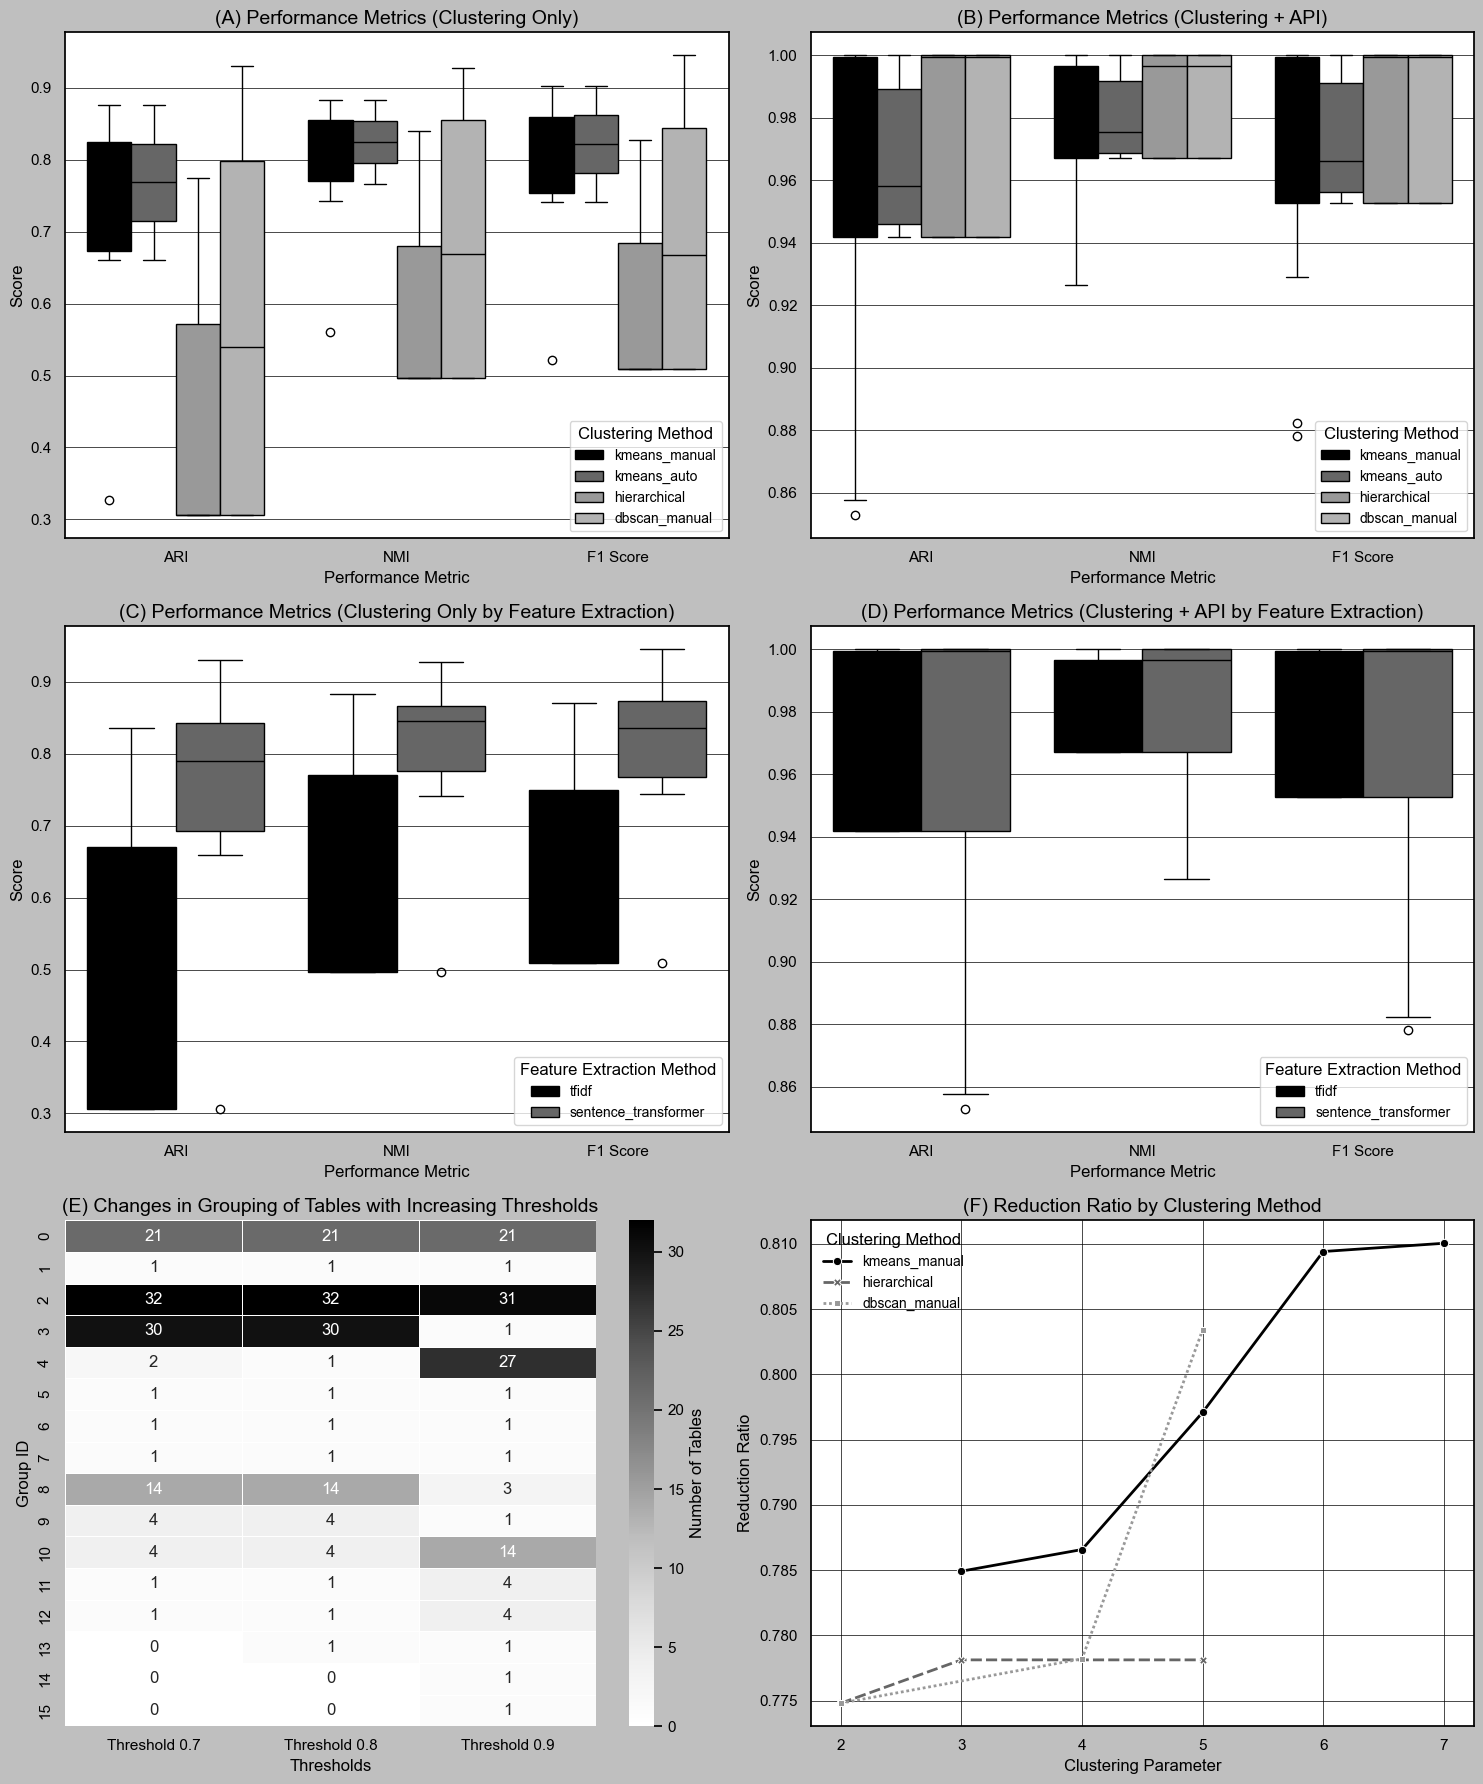

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
data = pd.read_csv("evaluation_results.csv")

# Calculate the total number of possible table pairs without any clustering
total_tables = 113
total_possible_pairs = total_tables * (total_tables - 1) / 2
print(f"Total possible pairs without clustering: {total_possible_pairs}")

# Filter data for clustering only experiments
clustering_only_data = data[data['experiment_type'] == 'clustering_only']
print("Clustering only data:")
print(clustering_only_data)

# Prepare data to analyze reduction in pairs based on clustering parameters from "clustering + API" experiments
reduction_ratios = []

# Iterate through clustering_only_data to assign clustering_param to relevant clustering + API rows
for _, row in clustering_only_data.iterrows():
    clustering_method = row['clustering_method']
    feature_extraction_method = row['feature_extraction_method']
    clustering_param = row['num_clusters'] if clustering_method != 'kmeans_auto' else 5
    
    # Get corresponding "clustering + API" rows with the same clustering method and feature extraction method
    relevant_api_data = data[
        (data['experiment_type'] == 'clustering + API') &
        (data['clustering_method'] == clustering_method) &
        (data['feature_extraction_method'] == feature_extraction_method) &
        (data['clustering_param'] == row['clustering_param'])
    ]
    
    # Assign clustering_param to relevant rows and calculate reduction ratios
    for _, api_row in relevant_api_data.iterrows():
        num_pairs_computed = api_row['num_pairs_to_compute']
        reduction_ratio = (total_possible_pairs - num_pairs_computed) / total_possible_pairs
        print(f"Clustering method: {clustering_method}, Clustering param: {clustering_param}, Num pairs computed: {num_pairs_computed}, Reduction ratio: {reduction_ratio}")
        reduction_ratios.append({
            'clustering_method': clustering_method,
            'clustering_param': clustering_param,
            'reduction_ratio': reduction_ratio
        })

# Convert to DataFrame for easy plotting
reduction_data = pd.DataFrame(reduction_ratios)
print("Reduction data:")
print(reduction_data)

# Set black-and-white style for better printing
sns.set(style="whitegrid", rc={'grid.color': '0.8', 'grid.linewidth': 0.5})
plt.style.use('grayscale')

# Plotting all figures and arranging them into a 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Plot 1: Reduction Ratio with clustering parameter as x-axis
sns.lineplot(data=reduction_data, x='clustering_param', y='reduction_ratio', hue='clustering_method', style='clustering_method', markers=True, dashes=True, linewidth=2, ax=axes[2, 1], ci=None)
axes[2, 1].set_xlabel('Clustering Parameter', fontsize=12)
axes[2, 1].set_ylabel('Reduction Ratio', fontsize=12)
axes[2, 1].legend(title='Clustering Method', fontsize=10, title_fontsize=12, frameon=False)
axes[2, 1].set_title('(F) Reduction Ratio by Clustering Method', fontsize=14)

# Plot 2: Performance Metrics with Clustering Only by Method
metrics = ['adjusted_rand_index', 'normalized_mutual_info', 'f1_score']
melted_data = clustering_only_data.melt(id_vars=['clustering_method', 'feature_extraction_method'], 
                                        value_vars=metrics, 
                                        var_name='Metric', 
                                        value_name='Score')
melted_data['Metric'] = melted_data['Metric'].replace({
    'adjusted_rand_index': 'ARI',
    'normalized_mutual_info': 'NMI',
    'f1_score': 'F1 Score'
})
sns.boxplot(data=melted_data, x='Metric', y='Score', hue='clustering_method', dodge=True, ax=axes[0, 0])
axes[0, 0].set_xlabel('Performance Metric', fontsize=12)
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].legend(title='Clustering Method', fontsize=10, title_fontsize=12)
axes[0, 0].set_title('(A) Performance Metrics (Clustering Only)', fontsize=14)

# Plot 3: Performance Metrics with Clustering + API by Method
clustering_api_data = data[data['experiment_type'] == 'clustering + API']
melted_data_api = clustering_api_data.melt(id_vars=['clustering_method', 'feature_extraction_method'], 
                                           value_vars=metrics, 
                                           var_name='Metric', 
                                           value_name='Score')
melted_data_api['Metric'] = melted_data_api['Metric'].replace({
    'adjusted_rand_index': 'ARI',
    'normalized_mutual_info': 'NMI',
    'f1_score': 'F1 Score'
})
sns.boxplot(data=melted_data_api, x='Metric', y='Score', hue='clustering_method', dodge=True, ax=axes[0, 1])
axes[0, 1].set_xlabel('Performance Metric', fontsize=12)
axes[0, 1].set_ylabel('Score', fontsize=12)
axes[0, 1].legend(title='Clustering Method', fontsize=10, title_fontsize=12)
axes[0, 1].set_title('(B) Performance Metrics (Clustering + API)', fontsize=14)

# Plot 4: Performance Metrics with Clustering Only by Feature Extraction Method
methods_data = data[(data['feature_extraction_method'] == 'tfidf') | (data['feature_extraction_method'] == 'sentence_transformer')]
clustering_only_data = methods_data[methods_data['experiment_type'] == 'clustering_only']
melted_clustering_only_data = clustering_only_data.melt(id_vars=['clustering_method', 'feature_extraction_method'],
                                                        value_vars=metrics,
                                                        var_name='Metric',
                                                        value_name='Score')
melted_clustering_only_data['Metric'] = melted_clustering_only_data['Metric'].replace({
    'adjusted_rand_index': 'ARI',
    'normalized_mutual_info': 'NMI',
    'f1_score': 'F1 Score'
})
sns.boxplot(data=melted_clustering_only_data, x='Metric', y='Score', hue='feature_extraction_method', dodge=True, ax=axes[1, 0])
axes[1, 0].set_xlabel('Performance Metric', fontsize=12)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].legend(title='Feature Extraction Method', fontsize=10, title_fontsize=12)
axes[1, 0].set_title('(C) Performance Metrics (Clustering Only by Feature Extraction)', fontsize=14)

# Plot 5: Performance Metrics with Clustering + API by Feature Extraction Method
clustering_api_data = methods_data[methods_data['experiment_type'] == 'clustering + API']
melted_clustering_api_data = clustering_api_data.melt(id_vars=['clustering_method', 'feature_extraction_method'],
                                                      value_vars=metrics,
                                                      var_name='Metric',
                                                      value_name='Score')
melted_clustering_api_data['Metric'] = melted_clustering_api_data['Metric'].replace({
    'adjusted_rand_index': 'ARI',
    'normalized_mutual_info': 'NMI',
    'f1_score': 'F1 Score'
})
sns.boxplot(data=melted_clustering_api_data, x='Metric', y='Score', hue='feature_extraction_method', dodge=True, ax=axes[1, 1])
axes[1, 1].set_xlabel('Performance Metric', fontsize=12)
axes[1, 1].set_ylabel('Score', fontsize=12)
axes[1, 1].legend(title='Feature Extraction Method', fontsize=10, title_fontsize=12)
axes[1, 1].set_title('(D) Performance Metrics (Clustering + API by Feature Extraction)', fontsize=14)

# Plot 6: Heatmap of Changes in Grouping of Tables with Increasing Similarity Thresholds
files = [
    "maude_schema_analysis/groupings_kmeans_manual_sim_0.7_param_3.csv",
    "maude_schema_analysis/groupings_kmeans_manual_sim_0.8_param_3.csv",
    "maude_schema_analysis/groupings_kmeans_manual_sim_0.9_param_3.csv"
]

thresholds = ["Threshold 0.7", "Threshold 0.8", "Threshold 0.9"]
groupings = []

data_dicts = []

# Load groupings from CSV files and calculate group sizes
dfs = []
for file, threshold in zip(files, thresholds):
    df = pd.read_csv(file)
    df['Tables Count'] = df['Tables'].apply(lambda x: len(x.split(', ')))
    dfs.append(df[['Group ID', 'Tables Count']])
    data_dicts.append({
        'Group ID': df['Group ID'].tolist(),
        'Tables Count': df['Tables Count'].tolist()
    })

# Create DataFrames for each threshold
data_07 = pd.DataFrame(data_dicts[0])
data_08 = pd.DataFrame(data_dicts[1])
data_09 = pd.DataFrame(data_dicts[2])

# Combine data into a summary DataFrame
summary_df = pd.DataFrame({
    "Threshold 0.7": data_07.set_index('Group ID')['Tables Count'],
    "Threshold 0.8": data_08.set_index('Group ID')['Tables Count'],
    "Threshold 0.9": data_09.set_index('Group ID')['Tables Count']
}).fillna(0)

# Plot heatmap of group changes with cross-threshold splitting information
sns.heatmap(summary_df, annot=True, cmap="Greys", cbar_kws={'label': 'Number of Tables'}, ax=axes[2, 0], linecolor='white', linewidths=0.5)
axes[2, 0].set_title("(E) Changes in Grouping of Tables with Increasing Thresholds", fontsize=14)
axes[2, 0].set_xlabel("Thresholds", fontsize=12)
axes[2, 0].set_ylabel("Group ID", fontsize=12)

plt.tight_layout()
plt.show()

找到宋体字体文件: /System/Library/Fonts/Supplemental/Songti.ttc
将使用宋体: /System/Library/Fonts/Supplemental/Songti.ttc
不使用聚类的可能表对总数: 6328.0
仅聚类数据:
    experiment_type clustering_method clustering_param  \
0   clustering_only     kmeans_manual                3   
4   clustering_only     kmeans_manual                3   
8   clustering_only     kmeans_manual                4   
12  clustering_only     kmeans_manual                4   
16  clustering_only     kmeans_manual                5   
20  clustering_only     kmeans_manual                5   
24  clustering_only     kmeans_manual                6   
28  clustering_only     kmeans_manual                6   
32  clustering_only     kmeans_manual                7   
36  clustering_only     kmeans_manual                7   
40  clustering_only       kmeans_auto              NaN   
44  clustering_only       kmeans_auto              NaN   
48  clustering_only      hierarchical              0.8   
52  clustering_only      hierarchical              

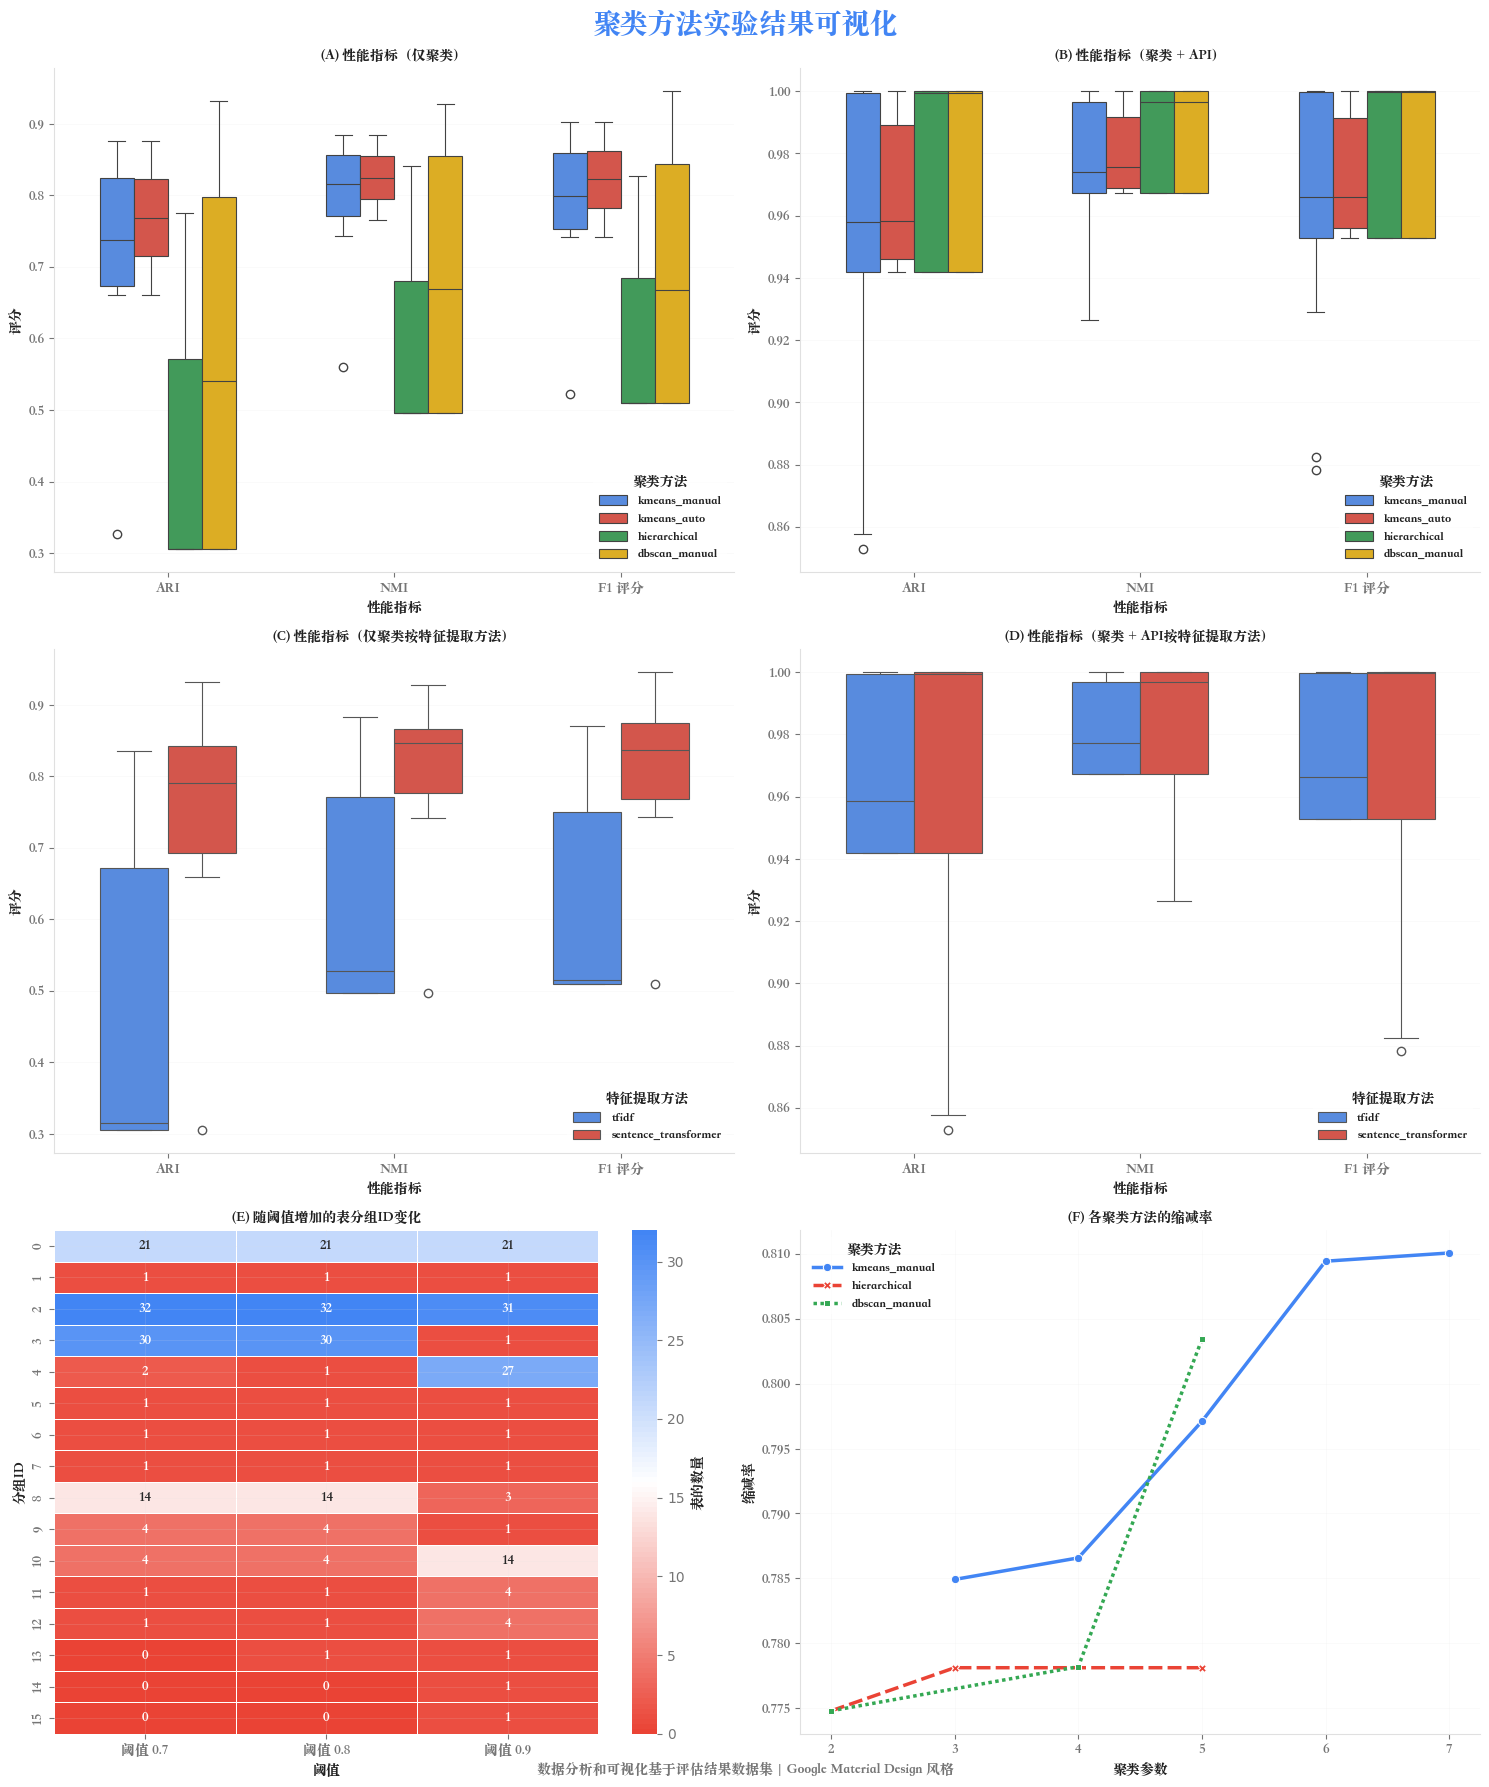

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl
import os
import warnings
from matplotlib.font_manager import FontProperties

# ========== 特定使用宋体字体设置 ==========
# 定义字体路径
windows_font_paths = [
    'C:/Windows/Fonts/SimSun.ttf',                   # 宋体（Windows）
    'C:/Windows/Fonts/NSimSun.ttf',                  # 新宋体
    'C:/Windows/Fonts/FangSong.ttf',                 # 仿宋
]

linux_font_paths = [
    '/usr/share/fonts/truetype/arphic/uming.ttc',    # AR PL UMing
    '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc',  # 文泉驿正黑
]

# macOS上宋体字体的优先顺序
songti_font_paths = [
    '/System/Library/Fonts/Supplemental/Songti.ttc', # 宋体 (macOS)
    '/Library/Fonts/Songti.ttc',                     # 宋体（另一位置）
]

# 忽略字体警告
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")

# 搜索宋体字体
possible_font_paths = songti_font_paths + windows_font_paths + linux_font_paths
font_found = False

for path in possible_font_paths:
    if os.path.exists(path):
        chinese_font_path = path
        font_found = True
        print(f"找到宋体字体文件: {path}")
        break  # 找到第一个可用的宋体字体后就停止

# 创建宋体字体对象
if font_found:
    chinese_font = FontProperties(fname=chinese_font_path)
    print(f"将使用宋体: {chinese_font_path}")
else:
    # 如果没有找到字体文件，尝试使用系统字体名称
    print("未找到宋体字体文件，尝试使用系统宋体名称")
    chinese_font = FontProperties(family=['Songti SC', 'SimSun', 'NSimSun', 'FangSong'])

# 全局应用中文字体设置
mpl.rcParams['font.family'] = ['sans-serif']
mpl.rcParams['font.sans-serif'] = ['Songti SC', 'SimSun', 'NSimSun', 'FangSong'] + mpl.rcParams.get('font.sans-serif', [])
mpl.rcParams['axes.unicode_minus'] = False  # 修复负号显示问题
mpl.rcParams['figure.figsize'] = (15, 18)   # 设置默认图形大小

# ========== Google Material Design配色方案 ==========
# 使用Google的品牌色和Material Design风格
google_colors = {
    # Google Logo颜色
    'google_blue': '#4285F4',     # Google蓝色
    'google_red': '#EA4335',      # Google红色
    'google_yellow': '#FBBC05',   # Google黄色
    'google_green': '#34A853',    # Google绿色
    
    # Material Design补充色
    'purple': '#9C27B0',          # Material紫色
    'teal': '#009688',            # Material青色
    'orange': '#FF9800',          # Material橙色
    'deep_purple': '#673AB7',     # Material深紫色
    
    # Material灰度
    'gray900': '#212121',         # 文本主色
    'gray600': '#757575',         # 次要文本
    'gray300': '#E0E0E0',         # 边框
    'gray100': '#F5F5F5',         # 背景色
    'white': '#FFFFFF',           # 白色
}

# 创建Google风格的热图色彩映射
from matplotlib.colors import LinearSegmentedColormap
google_heatmap_colors = [google_colors['google_red'], google_colors['white'], google_colors['google_blue']]
google_heatmap = LinearSegmentedColormap.from_list('google', google_heatmap_colors, N=100)

# 设置Material Design风格
plt.style.use('default')  # 重置样式
plt.rcParams['axes.labelcolor'] = google_colors['gray900']
plt.rcParams['text.color'] = google_colors['gray900']
plt.rcParams['axes.edgecolor'] = google_colors['gray300']
plt.rcParams['axes.spines.top'] = False      # 隐藏顶部轴线
plt.rcParams['axes.spines.right'] = False    # 隐藏右侧轴线
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = google_colors['gray300']
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['xtick.color'] = google_colors['gray600']
plt.rcParams['ytick.color'] = google_colors['gray600']

# 创建Google风格调色板
google_palette = [
    google_colors['google_blue'],
    google_colors['google_red'],
    google_colors['google_green'],
    google_colors['google_yellow']
]

# 创建双色调色板（特征提取方法用）
dual_palette = [google_colors['google_blue'], google_colors['google_red']]

# 设置图例字体大小配置
LEGEND_FONTSIZE = 12          # 图例文本字体大小（默认值）
LEGEND_TITLE_FONTSIZE = 14   # 图例标题字体大小（默认值）

# 自定义函数：使所有文本元素都使用宋体并设置字体大小
def apply_songti_font_to_axes(ax, chinese_font, legend_fontsize=LEGEND_FONTSIZE, legend_title_fontsize=LEGEND_TITLE_FONTSIZE):
    """将宋体应用到坐标轴的所有文本元素并设置字体大小"""
    # 坐标轴标签
    ax.set_xlabel(ax.get_xlabel(), fontproperties=chinese_font)
    ax.set_ylabel(ax.get_ylabel(), fontproperties=chinese_font)
    ax.set_title(ax.get_title(), fontproperties=chinese_font)
    
    # X轴刻度标签
    for label in ax.get_xticklabels():
        label.set_fontproperties(chinese_font)
    
    # Y轴刻度标签
    for label in ax.get_yticklabels():
        label.set_fontproperties(chinese_font)
    
    # 图例
    legend = ax.get_legend()
    if legend is not None:
        # 图例标题
        if legend.get_title().get_text():
            legend.get_title().set_fontproperties(chinese_font)
            legend.get_title().set_fontsize(legend_title_fontsize)
        # 图例项目
        for text in legend.get_texts():
            text.set_fontproperties(chinese_font)
            text.set_fontsize(legend_fontsize)

# 加载数据集
data = pd.read_csv("evaluation_results.csv")

# 计算不使用任何聚类的可能表对的总数
total_tables = 113
total_possible_pairs = total_tables * (total_tables - 1) / 2
print(f"不使用聚类的可能表对总数: {total_possible_pairs}")

# 过滤仅聚类实验的数据
clustering_only_data = data[data['experiment_type'] == 'clustering_only']
print("仅聚类数据:")
print(clustering_only_data)

# 准备数据以分析基于聚类参数的表对减少情况
reduction_ratios = []

# 遍历clustering_only_data以将聚类参数分配给相关的聚类+ API行
for _, row in clustering_only_data.iterrows():
    clustering_method = row['clustering_method']
    feature_extraction_method = row['feature_extraction_method']
    clustering_param = row['num_clusters'] if clustering_method != 'kmeans_auto' else 5
    
    # 获取具有相同聚类方法和特征提取方法的对应"聚类 + API"行
    relevant_api_data = data[
        (data['experiment_type'] == 'clustering + API') &
        (data['clustering_method'] == clustering_method) &
        (data['feature_extraction_method'] == feature_extraction_method) &
        (data['clustering_param'] == row['clustering_param'])
    ]
    
    # 为相关行分配聚类参数并计算缩减率
    for _, api_row in relevant_api_data.iterrows():
        num_pairs_computed = api_row['num_pairs_to_compute']
        reduction_ratio = (total_possible_pairs - num_pairs_computed) / total_possible_pairs
        print(f"聚类方法: {clustering_method}, 聚类参数: {clustering_param}, 计算的对数: {num_pairs_computed}, 缩减率: {reduction_ratio}")
        reduction_ratios.append({
            'clustering_method': clustering_method,
            'clustering_param': clustering_param,
            'reduction_ratio': reduction_ratio
        })

# 转换为DataFrame以便于绘图
reduction_data = pd.DataFrame(reduction_ratios)
print("缩减数据:")
print(reduction_data)

# 获取唯一的聚类方法数量
unique_methods = reduction_data['clustering_method'].nunique()
print(f"唯一的聚类方法数量: {unique_methods}")

# 绘制所有图形并将它们排列成3x2网格
fig, axes = plt.subplots(3, 2, figsize=(15, 18), dpi=100, facecolor=google_colors['white'])

# 应用Material Design风格到所有子图
for ax in axes.flatten():
    ax.set_facecolor(google_colors['white'])
    ax.tick_params(colors=google_colors['gray600'])
    ax.spines['bottom'].set_color(google_colors['gray300'])
    ax.spines['left'].set_color(google_colors['gray300'])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle='-', alpha=0.2, color=google_colors['gray300'])

# 中文标签文本
labels = {
    'title': '聚类方法实验结果可视化',
    'clustering_param': '聚类参数',
    'reduction_ratio': '缩减率',
    'clustering_method': '聚类方法',
    'metric': '性能指标',
    'score': '评分',
    'feature_extraction': '特征提取方法',
    'tables_count': '表的数量',
    'threshold': '阈值',
    'group_id': '分组ID',
    'f1_score': 'F1 评分',
    'clustering_only': '仅聚类',
    'clustering_api': '聚类 + API',
}

# 图1: 以聚类参数为x轴的缩减率 - Google风格
sns.lineplot(data=reduction_data, x='clustering_param', y='reduction_ratio', 
             hue='clustering_method', style='clustering_method', 
             markers=True, dashes=True, linewidth=2.5, 
             ax=axes[2, 1], errorbar=None, 
             palette=google_palette[:unique_methods])  # 只使用所需数量的颜色

# 使用宋体直接设置中文字体
axes[2, 1].set_xlabel(labels['clustering_param'], fontproperties=chinese_font, fontsize=12)
axes[2, 1].set_ylabel(labels['reduction_ratio'], fontproperties=chinese_font, fontsize=12)
axes[2, 1].set_title(f'(F) 各{labels["clustering_method"]}的{labels["reduction_ratio"]}', fontproperties=chinese_font, fontsize=14, color=google_colors['gray900'])

# 获取图例并修改字体及大小
legend = axes[2, 1].legend(title=labels['clustering_method'], frameon=True, framealpha=0.7, edgecolor='none')
legend.get_title().set_fontproperties(chinese_font)
legend.get_title().set_fontsize(LEGEND_TITLE_FONTSIZE)
# 设置图例项字体大小
for text in legend.get_texts():
    text.set_fontproperties(chinese_font)
    text.set_fontsize(LEGEND_FONTSIZE)
legend.get_frame().set_facecolor(google_colors['white'])

# 图2: 按方法的仅聚类性能指标 - Google风格
metrics = ['adjusted_rand_index', 'normalized_mutual_info', 'f1_score']
melted_data = clustering_only_data.melt(id_vars=['clustering_method', 'feature_extraction_method'], 
                                        value_vars=metrics, 
                                        var_name='Metric', 
                                        value_name='Score')
melted_data['Metric'] = melted_data['Metric'].replace({
    'adjusted_rand_index': 'ARI',
    'normalized_mutual_info': 'NMI',
    'f1_score': labels['f1_score']
})

# 获取唯一的聚类方法数量
unique_clustering_methods = melted_data['clustering_method'].nunique()
print(f"箱型图中唯一的聚类方法数量: {unique_clustering_methods}")

# Material Design风格的箱型图
sns.boxplot(data=melted_data, x='Metric', y='Score', hue='clustering_method', 
            dodge=True, ax=axes[0, 0], palette=google_palette[:unique_clustering_methods],
            width=0.6, linewidth=0.8)

axes[0, 0].set_xlabel(labels['metric'], fontproperties=chinese_font, fontsize=12)
axes[0, 0].set_ylabel(labels['score'], fontproperties=chinese_font, fontsize=12)
axes[0, 0].set_title(f'(A) {labels["metric"]}（{labels["clustering_only"]}）', fontproperties=chinese_font, fontsize=14, color=google_colors['gray900'])

# 修改所有刻度标签字体
for label in axes[0, 0].get_xticklabels():
    label.set_fontproperties(chinese_font)
        
# 获取图例并修改字体
legend = axes[0, 0].legend(title=labels['clustering_method'], frameon=True, framealpha=0.7, edgecolor='none')
legend.get_title().set_fontproperties(chinese_font)
legend.get_frame().set_facecolor(google_colors['white'])

# 图3: 按方法的聚类 + API性能指标 - Google风格
clustering_api_data = data[data['experiment_type'] == 'clustering + API']
melted_data_api = clustering_api_data.melt(id_vars=['clustering_method', 'feature_extraction_method'], 
                                          value_vars=metrics, 
                                          var_name='Metric', 
                                          value_name='Score')
melted_data_api['Metric'] = melted_data_api['Metric'].replace({
    'adjusted_rand_index': 'ARI',
    'normalized_mutual_info': 'NMI',
    'f1_score': labels['f1_score']
})

# 获取API数据中唯一的聚类方法数量
unique_api_methods = melted_data_api['clustering_method'].nunique()
api_palette = google_palette[:unique_api_methods]

sns.boxplot(data=melted_data_api, x='Metric', y='Score', hue='clustering_method', 
            dodge=True, ax=axes[0, 1], palette=api_palette,
            width=0.6, linewidth=0.8)

axes[0, 1].set_xlabel(labels['metric'], fontproperties=chinese_font, fontsize=12)
axes[0, 1].set_ylabel(labels['score'], fontproperties=chinese_font, fontsize=12)
axes[0, 1].set_title(f'(B) {labels["metric"]}（{labels["clustering_api"]}）', fontproperties=chinese_font, fontsize=14, color=google_colors['gray900'])

# 修改所有刻度标签字体
for label in axes[0, 1].get_xticklabels():
    label.set_fontproperties(chinese_font)
        
# 获取图例并修改字体
legend = axes[0, 1].legend(title=labels['clustering_method'], frameon=True, framealpha=0.7, edgecolor='none')
legend.get_title().set_fontproperties(chinese_font)
legend.get_frame().set_facecolor(google_colors['white'])

# 图4: 按特征提取方法的仅聚类性能指标 - Google风格
methods_data = data[(data['feature_extraction_method'] == 'tfidf') | (data['feature_extraction_method'] == 'sentence_transformer')]
clustering_only_data = methods_data[methods_data['experiment_type'] == 'clustering_only']
melted_clustering_only_data = clustering_only_data.melt(id_vars=['clustering_method', 'feature_extraction_method'],
                                                      value_vars=metrics,
                                                      var_name='Metric',
                                                      value_name='Score')
melted_clustering_only_data['Metric'] = melted_clustering_only_data['Metric'].replace({
    'adjusted_rand_index': 'ARI',
    'normalized_mutual_info': 'NMI',
    'f1_score': labels['f1_score']
})

sns.boxplot(data=melted_clustering_only_data, x='Metric', y='Score', hue='feature_extraction_method', 
            dodge=True, ax=axes[1, 0], palette=dual_palette,
            width=0.6, linewidth=0.8)

axes[1, 0].set_xlabel(labels['metric'], fontproperties=chinese_font, fontsize=12)
axes[1, 0].set_ylabel(labels['score'], fontproperties=chinese_font, fontsize=12)
axes[1, 0].set_title(f'(C) {labels["metric"]}（{labels["clustering_only"]}按{labels["feature_extraction"]}）', fontproperties=chinese_font, fontsize=14, color=google_colors['gray900'])

# 修改所有刻度标签字体
for label in axes[1, 0].get_xticklabels():
    label.set_fontproperties(chinese_font)
        
# 获取图例并修改字体
legend = axes[1, 0].legend(title=labels['feature_extraction'], frameon=True, framealpha=0.7, edgecolor='none')
legend.get_title().set_fontproperties(chinese_font)
legend.get_frame().set_facecolor(google_colors['white'])

# 图5: 按特征提取方法的聚类 + API性能指标 - Google风格
clustering_api_data = methods_data[methods_data['experiment_type'] == 'clustering + API']
melted_clustering_api_data = clustering_api_data.melt(id_vars=['clustering_method', 'feature_extraction_method'],
                                                    value_vars=metrics,
                                                    var_name='Metric',
                                                    value_name='Score')
melted_clustering_api_data['Metric'] = melted_clustering_api_data['Metric'].replace({
    'adjusted_rand_index': 'ARI',
    'normalized_mutual_info': 'NMI',
    'f1_score': labels['f1_score']
})

sns.boxplot(data=melted_clustering_api_data, x='Metric', y='Score', hue='feature_extraction_method', 
            dodge=True, ax=axes[1, 1], palette=dual_palette,
            width=0.6, linewidth=0.8)

axes[1, 1].set_xlabel(labels['metric'], fontproperties=chinese_font, fontsize=12)
axes[1, 1].set_ylabel(labels['score'], fontproperties=chinese_font, fontsize=12)
axes[1, 1].set_title(f'(D) {labels["metric"]}（{labels["clustering_api"]}按{labels["feature_extraction"]}）', fontproperties=chinese_font, fontsize=14, color=google_colors['gray900'])

# 修改所有刻度标签字体
for label in axes[1, 1].get_xticklabels():
    label.set_fontproperties(chinese_font)
        
# 获取图例并修改字体
legend = axes[1, 1].legend(title=labels['feature_extraction'], frameon=True, framealpha=0.7, edgecolor='none')
legend.get_title().set_fontproperties(chinese_font)
legend.get_frame().set_facecolor(google_colors['white'])

# 图6: 随阈值增加的表分组变化热图 - Google风格
files = [
    "maude_schema_analysis/groupings_kmeans_manual_sim_0.7_param_3.csv",
    "maude_schema_analysis/groupings_kmeans_manual_sim_0.8_param_3.csv",
    "maude_schema_analysis/groupings_kmeans_manual_sim_0.9_param_3.csv"
]

thresholds = [f"{labels['threshold']} 0.7", f"{labels['threshold']} 0.8", f"{labels['threshold']} 0.9"]
groupings = []

data_dicts = []

# 从CSV文件加载分组并计算组大小
dfs = []
for file, threshold in zip(files, thresholds):
    df = pd.read_csv(file)
    df['Tables Count'] = df['Tables'].apply(lambda x: len(x.split(', ')))
    dfs.append(df[['Group ID', 'Tables Count']])
    data_dicts.append({
        'Group ID': df['Group ID'].tolist(),
        'Tables Count': df['Tables Count'].tolist()
    })

# 为每个阈值创建DataFrame
data_07 = pd.DataFrame(data_dicts[0])
data_08 = pd.DataFrame(data_dicts[1])
data_09 = pd.DataFrame(data_dicts[2])

# 将数据合并到摘要DataFrame中
summary_df = pd.DataFrame({
    thresholds[0]: data_07.set_index('Group ID')['Tables Count'],
    thresholds[1]: data_08.set_index('Group ID')['Tables Count'],
    thresholds[2]: data_09.set_index('Group ID')['Tables Count']
}).fillna(0)

# 绘制带有Google风格的热图
heatmap = sns.heatmap(summary_df, annot=True, cmap=google_heatmap, 
                    cbar_kws={'label': labels['tables_count']}, 
                    ax=axes[2, 0], linecolor=google_colors['white'], linewidths=0.5)

axes[2, 0].set_title(f"(E) 随{labels['threshold']}增加的表{labels['group_id']}变化", fontproperties=chinese_font, fontsize=14, color=google_colors['gray900'])
axes[2, 0].set_xlabel(labels['threshold'], fontproperties=chinese_font, fontsize=12)
axes[2, 0].set_ylabel(labels['group_id'], fontproperties=chinese_font, fontsize=12)

# 确保热图注释使用宋体
for text in heatmap.texts:
    text.set_fontproperties(chinese_font)

# 修改colorbar标签字体
cbar = heatmap.collections[0].colorbar
cbar.set_label(labels['tables_count'], fontproperties=chinese_font)

# 修改x轴刻度标签字体
for tick in axes[2, 0].get_xticklabels():
    tick.set_fontproperties(chinese_font)

# 应用宋体到所有子图并设置统一的图例字体大小
for ax in axes.flatten():
    apply_songti_font_to_axes(ax, chinese_font, LEGEND_FONTSIZE, LEGEND_TITLE_FONTSIZE)

# Google风格的全局标题
fig.suptitle(labels['title'], fontproperties=chinese_font, fontsize=20, y=0.99, 
             color=google_colors['google_blue'], fontweight='bold')
fig.subplots_adjust(top=0.95)

# 添加Google风格的底部注释
fig.text(0.5, 0.01, 
         '数据分析和可视化基于评估结果数据集 | Google Material Design 风格',
         fontproperties=chinese_font, ha='center', color=google_colors['gray600'], fontsize=10)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

# 如何修改图例字体大小：
# 1. 修改代码开头的 LEGEND_FONTSIZE 和 LEGEND_TITLE_FONTSIZE 值
# 2. 更大的数值 = 更大的字体，更小的数值 = 更小的字体
# 3. 默认值分别为 9 和 10，可以根据需要调整

# 图例字体大小调整示例:
# LEGEND_FONTSIZE = 8        # 更小的图例项字体
# LEGEND_FONTSIZE = 11       # 更大的图例项字体
# LEGEND_TITLE_FONTSIZE = 9  # 更小的图例标题
# LEGEND_TITLE_FONTSIZE = 12 # 更大的图例标题

# 可选：保存图像到文件
# fig.savefig('聚类实验结果-Google风格-宋体.png', dpi=300, bbox_inches='tight')